In [1]:
import time
from datetime import date
import pandas as pd
import os
import glob
import pycytominer
import sys
import CBE_utils as CBE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import correlation
import re
import gc

In [2]:
import importlib
importlib.reload(CBE)

<module 'CBE_utils' from '/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/notebooks_revision/CBE_utils.py'>

In [3]:
input_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/output/"
output_path = input_path

figure_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/results/"

annotation_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/annotation/"
feature_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/features_reduced/"

In [4]:
def get_pos_control_correlation(input_dataframe, pos_ctrl_string, input_features):
    
    pos_ctrl_dataframe = input_dataframe.loc[input_dataframe['Metadata_RoughID'] == pos_ctrl_string]

    corr_pos_ctrl = None

    if (len(pos_ctrl_dataframe) == 2 ):

        well_1_features = pos_ctrl_dataframe.iloc[0][input_features].values
        well_2_features = pos_ctrl_dataframe.iloc[1][input_features].values
    
        corr = np.corrcoef(well_1_features.astype(float), well_2_features.astype(float))
        np.fill_diagonal(corr, np.nan)

        corr_pos_ctrl = np.nanmedian(corr)

    return corr_pos_ctrl

In [5]:
def get_median_pos_ctrl_correlation(input_dataframe, input_features):

    tetrandrine_dataframe = input_dataframe.loc[input_dataframe['Metadata_RoughID'] == 'Tetrandrine']
    tetrandrine_median_features = tetrandrine_dataframe[input_features].median(axis=0)

    nocodazole_dataframe = input_dataframe.loc[input_dataframe['Metadata_RoughID'] == 'Nocodazole']
    nocodazole_median_features = nocodazole_dataframe[input_features].median(axis=0)
    
    corr = np.corrcoef(tetrandrine_median_features.astype(float), nocodazole_median_features.astype(float))
    np.fill_diagonal(corr, np.nan)

    return np.nanmedian(corr)

In [6]:
def pad_numbers(value):
    match = re.match(r"([A-Z])(\d+)", value)
    if match:
        letter = match.group(1)
        number = match.group(2).zfill(2)  # Pad number to 2 digits
        return f"{letter}{number}"
    return value

In [7]:
# get folder list 
# load for each site the normalized files
# reduce the features selecting the correct feature list
folders = [name for name in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, name))]

In [ ]:
dataframes_normalized_reduced_dict = {}

for folder in folders:

    site_specific_path = os.path.join(input_path, folder)

    # loads mad_robustize normalized data
    pattern = "[A-Z]*_R[1-4]_mad_robustize_reduced-corr.csv"
    file_list = glob.glob(site_specific_path + os.sep + '*' + os.sep + pattern, recursive=True)

    for file in file_list:
    
        plate_map_name = os.path.splitext(os.path.basename(file))[0]
    
        try:
        
            dataframe = pd.read_csv(file)
            row_count = dataframe.shape[0]
        
            print(f"INFO: {plate_map_name} has {row_count} rows")

            dict_key = dataframe['Metadata_staining_date'][0].astype(str) + "_" + dataframe['Metadata_source'][0] + "_" + dataframe['Metadata_plate_map_name'][0]

            dataframes_normalized_reduced_dict[dict_key] = dataframe
        
        except Exception as e:
        
            print(f"Error reading file {plate_map_name}: {e}") 

INFO: C1269_R2_mad_robustize_reduced-corr has 384 rows
INFO: C1242_R2_mad_robustize_reduced-corr has 384 rows
INFO: C1284_R4_mad_robustize_reduced-corr has 384 rows
INFO: C1288_R1_mad_robustize_reduced-corr has 384 rows
INFO: A1302_R2_mad_robustize_reduced-corr has 384 rows
INFO: C1240_R4_mad_robustize_reduced-corr has 384 rows
INFO: A1292_R2_mad_robustize_reduced-corr has 384 rows
INFO: C1242_R3_mad_robustize_reduced-corr has 384 rows
INFO: C1260_R1_mad_robustize_reduced-corr has 384 rows
INFO: A1292_R3_mad_robustize_reduced-corr has 384 rows
INFO: A1299_R2_mad_robustize_reduced-corr has 384 rows
INFO: A1293_R3_mad_robustize_reduced-corr has 384 rows
INFO: C1258_R2_mad_robustize_reduced-corr has 384 rows
INFO: C1270_R3_mad_robustize_reduced-corr has 384 rows
INFO: C1259_R1_mad_robustize_reduced-corr has 384 rows
INFO: C1283_R2_mad_robustize_reduced-corr has 384 rows
INFO: A1303_R1_mad_robustize_reduced-corr has 384 rows
INFO: C1288_R3_mad_robustize_reduced-corr has 384 rows
INFO: C123

In [9]:
imaging_date = []
staining_date = []
plate_name = []
replicate_number = []
plate_map_name = []
plate_code_list = []
user = []
source = []
picklist_name = []
noco_corr = []
tet_corr = []
pos_ctrl_corr = []
test_corr_noco_all = {}
test_corr_tet_all = {}
test_corr_pos_ctrl_all = {}

for plate_code in dataframes_normalized_reduced_dict:
    
    layout_dictionary = {'R1':'Picklist_Replicate1.csv',
                     'R2':'Picklist_Replicate2.csv',
                     'R3':'Picklist_Replicate3.csv',
                     'R4':'Picklist_Replicate4.csv'
                    }

    
    print(f"Testing {plate_code}")
    
    dataframe_for_QC1 = dataframes_normalized_reduced_dict[plate_code]
    
    print(f"Original layout is {dataframe_for_QC1['Metadata_replicate_number'][0]}")
    
    features = CBE.get_feature_vector(dataframe_for_QC1)
    metadata_dataframe = set(dataframe_for_QC1.columns) - set(features)
    
    ### convert sets to list
    features_list = list(features)
    metadata_list = list(metadata_dataframe)
    
    imaging_date.append(dataframe_for_QC1['Metadata_imaging_date'][0])
    staining_date.append(dataframe_for_QC1['Metadata_staining_date'][0])
    plate_name.append(dataframe_for_QC1['Metadata_plate_name'][0])
    replicate_number.append(dataframe_for_QC1['Metadata_replicate_number'][0])
    plate_map_name.append(dataframe_for_QC1['Metadata_plate_map_name'][0])
    plate_code_list.append(plate_code)
    user.append(dataframe_for_QC1['Metadata_user'][0])
    source.append(dataframe_for_QC1['Metadata_source'][0])
    picklist_name.append(dataframe_for_QC1['Metadata_picklist_name'][0])
    noco_corr.append(get_pos_control_correlation(dataframe_for_QC1, 'Nocodazole', features_list))
    tet_corr.append(get_pos_control_correlation(dataframe_for_QC1, 'Tetrandrine', features_list))
    pos_ctrl_corr.append(get_median_pos_ctrl_correlation(dataframe_for_QC1, features_list))
    
    test_corr_noco = {}
    test_corr_tet = {}
    test_corr_pos_ctrl = {}
    
    # test through all layouts including original 
    for layout_number in layout_dictionary:
    
        # create copy from orginal QC dataframe
        dataframe_for_QC_test = dataframe_for_QC1.copy()

        # remove columns associated with original well info
        dataframe_for_QC_test = dataframe_for_QC_test.drop(['Metadata_RoughID', 'Metadata_picklist_name', 'Metadata_Well'], axis=1)

        # add ID to make sure we know and it does not contaminate our data
        dataframe_for_QC_test['Metadata_picklist_name'] = 'test_layout_' + layout_number

        plate_layout_path = os.path.join(annotation_dir, 'plate_layout', layout_dictionary[layout_number])
        plate_layout = pd.read_csv(plate_layout_path)

        # Issue in the plate layout the well numbers are not padded
        plate_layout['Destination Well'] = plate_layout['Destination Well'].apply(pad_numbers)
        plate_layout['Source Well'] = plate_layout['Source Well'].apply(pad_numbers)

        # rename the columns accordingly
        plate_layout = plate_layout.rename(columns={"Destination Well": "Metadata_Well_randomized"})
        plate_layout = plate_layout.rename(columns={"Source Well": "Metadata_Well"})
         
        dataframe_for_QC_test = pd.merge(dataframe_for_QC_test, plate_layout, on='Metadata_Well_randomized')

        # get info for pos. and neg. controls
        controls_layout_path = os.path.join(annotation_dir, "pos_neg_ctrl.csv")
        controls_layout = pd.read_csv(controls_layout_path)

        # Issue in the plate layout the well numbers are not padded
        controls_layout['Metadata_Well'] = controls_layout['Metadata_Well'].apply(pad_numbers)

        dataframe_for_QC_test = pd.merge(dataframe_for_QC_test, controls_layout, on='Metadata_Well')
        
        test_corr_noco['Layout_test_noco_' + layout_number] = get_pos_control_correlation(dataframe_for_QC_test, 'Nocodazole', features_list)
        test_corr_tet['Layout_test_tet_' + layout_number] = get_pos_control_correlation(dataframe_for_QC_test, 'Tetrandrine', features_list)
        test_corr_pos_ctrl['Layout_test_pos_ctrl_' + layout_number] = get_median_pos_ctrl_correlation(dataframe_for_QC_test, features_list)
    
        del dataframe_for_QC_test
        gc.collect()
        
        
    test_corr_noco_all[plate_code] = test_corr_noco
    test_corr_tet_all[plate_code] = test_corr_tet
    test_corr_pos_ctrl_all[plate_code] = test_corr_pos_ctrl
    

quality_control_1 = {
    'Metadata_imaging_date': imaging_date,
    'Metadata_staining_date': staining_date,
    'Metadata_plate_name': plate_name,
    'Metadata_replicate_number': replicate_number,
    'Metadata_plate_map_name': plate_map_name,
    'Metadata_plate_code': plate_code_list,
    'Metadata_user': user,
    'Metadata_source':source,
    'Metadata_noco_corr': noco_corr,
    'Metadata_tet_corr': tet_corr,
    'Metadata_pos_ctrl_corr': pos_ctrl_corr
}

Testing 240816_IMTM_C1269_R2
Original layout is R2
Testing 250108_IMTM_C1242_R2
Original layout is R2
Testing 0_IMTM_C1284_R4
Original layout is R4
Testing 241101_IMTM_C1288_R1
Original layout is R1
Testing 250415_IMTM_A1302_R2
Original layout is R2
Testing 240621_IMTM_C1240_R4
Original layout is R4
Testing 250415_IMTM_A1292_R2
Original layout is R2
Testing 250110_IMTM_C1242_R3
Original layout is R3
Testing 240717_IMTM_C1260_R1
Original layout is R1
Testing 250418_IMTM_A1292_R3
Original layout is R3
Testing 250415_IMTM_A1299_R2
Original layout is R2
Testing 250418_IMTM_A1293_R3
Original layout is R3
Testing 240724_IMTM_C1258_R2
Original layout is R2
Testing 240822_IMTM_C1270_R3
Original layout is R3
Testing 240717_IMTM_C1259_R1
Original layout is R1
Testing 241101_IMTM_C1283_R2
Original layout is R2
Testing 250528_IMTM_A1303_R1
Original layout is R1
Testing 250521_IMTM_C1288_R3
Original layout is R3
Testing 250110_IMTM_C1238_R3
Original layout is R3
Testing 240717_IMTM_C1261_R1
Origina

/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Testing 250110_IMTM_C1241_R3
Original layout is R3
Testing 240815_IMTM_C1262_R3
Original layout is R3
Testing 160824_IMTM_C1262_R4
Original layout is R4
Testing 240725_IMTM_C1259_R3
Original layout is R3
Testing 241115_IMTM_C1286_R3
Original layout is R3
Testing 250418_IMTM_A1300_R3
Original layout is R3
Testing 240724_IMTM_C1259_R2
Original layout is R2
Testing 250108_IMTM_C1241_R2
Original layout is R2
Testing 240816_IMTM_C1267_R2
Original layout is R2
Testing 250522_IMTM_A1304_R4
Original layout is R4
Testing 240814_IMTM_C1258_R4
Original layout is R4
Testing 250521_IMTM_A1303_R3
Original layout is R3
Testing 250514_IMTM_A1308_R1
Original layout is R1
Testing 241204_IMTM_C1289_R2
Original layout is R2
Testing 240904_IMTM_C1266_R4
Original layout is R4
Testing 240717_IMTM_C1258_R1
Original layout is R1
Testing 240814_IMTM_C1257_R4
Original layout is R4
Testing 241128_IMTM_C1287_R4
Original layout is R4
Testing 240822_IMTM_C1273_R1
Original layout is R1
Testing 240711_IMTM_C1244_R3
Or

/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Testing 240711_IMTM_C1248_R3
Original layout is R3
Testing 240619_IMTM_C1237_R4
Original layout is R4
Testing 250528_IMTM_C1275_R3
Original layout is R3
Testing 250514_IMTM_A1305_R1
Original layout is R1
Testing 240612_IMTM_C1236_R3
Original layout is R3
Testing 241211_IMTM_C1291_R4
Original layout is R4
Testing 241101_IMTM_C1282_R2
Original layout is R2
Testing 240724_IMTM_C1262_R1
Original layout is R1
Testing 240815_IMTM_C1265_R3
Original layout is R3
Testing 250514_IMTM_A1309_R1
Original layout is R1
Testing 240605_IMTM_C1233_R2
Original layout is R2
Testing 240906_IMTM_C1276_R3
Original layout is R3
Testing 240822_IMTM_C1271_R3
Original layout is R3
Testing 250516_IMTM_A1306_R2
Original layout is R2
Testing 240717_IMTM_C1253_R3
Original layout is R3
Testing 0_IMTM_C1288_R1
Original layout is R1


/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Testing 0_IMTM_C1283_R4
Original layout is R4
Testing 241009_USC_C1198_R3
Original layout is R3
Testing 241024_USC_C1216_R4
Original layout is R4
Testing 240927_USC_C1226_R1
Original layout is R1
Testing 250508_USC_C1193_R2
Original layout is R2
Testing 241002_USC_C1206_R2
Original layout is R2
Testing 250604_USC_C1192_R1
Original layout is R1
Testing 240726_USC_C1169_R4
Original layout is R4
Testing 240726_USC_C1167_R4
Original layout is R4
Testing 240628_USC_C1184_R1
Original layout is R1
Testing 240730_USC_C1181_R4
Original layout is R4
Testing 241011_USC_C1213_R3
Original layout is R3
Testing 240703_USC_C1166_R2
Original layout is R2
Testing 241009_USC_C1202_R3
Original layout is R3
Testing 240619_USC_C1162_R4
Original layout is R4
Testing 250425_USC_C1159_R1
Original layout is R1
Testing 240912_USC_C1193_R1
Original layout is R1
Testing 240920_USC_C1220_R1
Original layout is R1
Testing 240627_USC_C1175_R1
Original layout is R1
Testing 241009_USC_C1193_R3
Original layout is R3
Test

/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Testing 240719_USC_C1192_R3
Original layout is R3
Testing 240918_USC_C1207_R1
Original layout is R1
Testing 240726_USC_C1171_R4
Original layout is R4
Testing 241018_USC_C1199_R4
Original layout is R4
Testing 240726_USC_C1166_R4
Original layout is R4
Testing 241024_USC_C1220_R4
Original layout is R4
Testing 240710_USC_C1182_R2
Original layout is R2
Testing 241009_USC_C1195_R3
Original layout is R3
Testing 241018_USC_C1202_R4
Original layout is R4
Testing 240724_USC_C1182_R4
Original layout is R4
Testing 250430_USC_C1159_R3
Original layout is R3
Testing 240711_USC_C1172_R3
Original layout is R3
Testing 240726_USC_C1173_R4
Original layout is R4
Testing 240710_USC_C1188_R2
Original layout is R2
Testing 240912_USC_C1200_R1
Original layout is R1
Testing 240912_USC_C1197_R1
Original layout is R1
Testing 241025_USC_C1228_R4
Original layout is R4
Testing 240704_USC_C1179_R2
Original layout is R2
Testing 241002_USC_C1208_R2
Original layout is R2
Testing 240710_USC_C1189_R2
Original layout is R2


/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Testing 250507_USC_C1186_R2
Original layout is R2
Testing 241025_USC_C1190_R4
Original layout is R4
Testing 241024_USC_C1217_R4
Original layout is R4
Testing 240926_USC_C1198_R2
Original layout is R2
Testing 241010_USC_C1212_R3
Original layout is R3
Testing 250509_USC_C1226_R1
Original layout is R1
Testing 240627_USC_C1180_R1
Original layout is R1
Testing 241023_USC_C1206_R4
Original layout is R4
Testing 250507_USC_C1172_R4
Original layout is R4


/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Testing 250507_USC_C1162_R4
Original layout is R4
Testing 240730_USC_C1175_R4
Original layout is R4
Testing 240628_USC_C1186_R1
Original layout is R1
Testing 241009_USC_C1201_R3
Original layout is R3
Testing 240719_USC_C1186_R3
Original layout is R3
Testing 241010_USC_C1205_R3
Original layout is R3
Testing 240704_USC_C1180_R2
Original layout is R2
Testing 250508_USC_C1188_R2
Original layout is R2
Testing 250430_USC_C1161_R3
Original layout is R3
Testing 240704_USC_C1174_R2
Original layout is R2
Testing 240927_USC_C1223_R1
Original layout is R1
Testing 240730_USC_C1174_R4
Original layout is R4
Testing 240719_USC_C1187_R3
Original layout is R3
Testing 240626_USC_C1172_R1
Original layout is R1
Testing 250507_USC_C1158_R4
Original layout is R4
Testing 240627_USC_C1178_R1
Original layout is R1
Testing 240918_USC_C1208_R1
Original layout is R1
Testing 241024_USC_C1221_R4
Original layout is R4
Testing 240628_USC_C1181_R1
Original layout is R1
Testing 241018_USC_C1193_R4
Original layout is R4


/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Testing 241018_FMP_C1123_R2
Original layout is R2
Testing 241106_FMP_C1120_R3
Original layout is R3
Testing 240717_FMP_C1099_R3
Original layout is R3
Testing 241210_FMP_C1134_R2
Original layout is R2
Testing 240710_FMP_C1099_R2
Original layout is R2
Testing 240605_FMP_C1085_R1
Original layout is R1
Testing 240906_FMP_C1110_R2
Original layout is R2
Testing 250226_FMP_C1126_R3
Original layout is R3
Testing 241113_FMP_C1117_R4
Original layout is R4
Testing 250226_FMP_C1132_R3
Original layout is R3
Testing 240718_FMP_C1103_R4
Original layout is R4
Testing 240626_FMP_C1099_R1
Original layout is R1
Testing 241106_FMP_C1123_R3
Original layout is R3
Testing 241002_FMP_C1104_R4
Original layout is R4
Testing 241113_FMP_C1115_R4
Original layout is R4
Testing 240906_FMP_C1111_R2
Original layout is R2
Testing 240904_FMP_C1108_R1
Original layout is R1
Testing 241106_FMP_C1117_R3
Original layout is R3
Testing 240717_FMP_C1097_R3
Original layout is R3
Testing 241113_FMP_C1122_R4
Original layout is R4


/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Testing 240906_FMP_C1107_R2
Original layout is R2
Testing 240906_FMP_C1105_R2
Original layout is R2
Testing 240626_FMP_C1094_R1
Original layout is R1
Testing 241002_FMP_C1122_R1
Original layout is R1
Testing 250228_FMP_C1127_R4
Original layout is R4
Testing 240718_FMP_C1094_R4
Original layout is R4
Testing 240626_FMP_C1095_R1
Original layout is R1
Testing 240911_FMP_C1105_R3
Original layout is R3
Testing 240621_FMP_C1088_R4
Original layout is R4
Testing 240614_FMP_C1092_R2
Original layout is R2
Testing 240614_FMP_C1086_R2
Original layout is R2
Testing 250228_FMP_C1131_R4
Original layout is R4
Testing 241113_FMP_C1116_R4
Original layout is R4
Testing 240906_FMP_C1106_R2
Original layout is R2
Testing 240605_FMP_C1091_R1
Original layout is R1
Testing 241002_FMP_C1112_R4
Original layout is R4
Testing 250228_FMP_C1134_R4
Original layout is R4
Testing 241210_FMP_C1124_R2
Original layout is R2
Testing 241106_FMP_C1121_R3
Original layout is R3
Testing 240626_FMP_C1098_R1
Original layout is R1


/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/schmiedc/miniconda3/envs/vspaint/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k 

Testing 241108_MEDINA_C1059_R2
Original layout is R2
Testing 241023_MEDINA_C1045_R2
Original layout is R2
Testing 241031_MEDINA_C1025_R3
Original layout is R3
Testing 240912_MEDINA_C1023_R2
Original layout is R2
Testing 240911_MEDINA_C1021_R1
Original layout is R1
Testing 241031_MEDINA_C1022_R3
Original layout is R3
Testing 241107_MEDINA_C1057_R1
Original layout is R1
Testing 241122_MEDINA_C1052_R4
Original layout is R4
Testing 240927_MEDINA_C1046_R1
Original layout is R1
Testing 241107_MEDINA_C1083_R1
Original layout is R1
Testing 250516_MEDINA_C1042_R2
Original layout is R2
Testing 240911_MEDINA_C1029_R1
Original layout is R1
Testing 241108_MEDINA_C1052_R2
Original layout is R2
Testing 241025_MEDINA_C1044_R4
Original layout is R4
Testing 241121_MEDINA_C1059_R3
Original layout is R3
Testing 250123_MEDINA_C1070_R4
Original layout is R4
Testing 241108_MEDINA_C1058_R2
Original layout is R2
Testing 240718_MEDINA_C1016_R2
Original layout is R2
Testing 240911_MEDINA_C1025_R1
Original layout

In [10]:
quality_control_1_df = pd.DataFrame(quality_control_1)

quality_control_1_noco_test_corr = pd.DataFrame.from_dict(test_corr_noco_all, orient='index')
quality_control_1_noco_test_corr = quality_control_1_noco_test_corr.reset_index().rename(columns={"index":"Metadata_plate_code"})

quality_control_1_tet_test_corr = pd.DataFrame.from_dict(test_corr_tet_all, orient='index')
quality_control_1_tet_test_corr = quality_control_1_tet_test_corr.reset_index().rename(columns={"index":"Metadata_plate_code"})

quality_control_1_pos_ctrl_corr = pd.DataFrame.from_dict(test_corr_pos_ctrl_all, orient='index')
quality_control_1_pos_ctrl_corr = quality_control_1_pos_ctrl_corr.reset_index().rename(columns={"index":"Metadata_plate_code"})

test_correlations = pd.merge(quality_control_1_noco_test_corr, quality_control_1_tet_test_corr, on='Metadata_plate_code')
test_correlations = pd.merge(test_correlations, quality_control_1_pos_ctrl_corr, on='Metadata_plate_code')

In [11]:
quality_control_1_df = pd.DataFrame(quality_control_1) 

source_list = quality_control_1_df['Metadata_source'].unique()

for source in source_list:
    
    qc_1_source = quality_control_1_df[quality_control_1_df['Metadata_source'] == source]

    name = 'quality_control_1_' + source + '.csv'
    file_path_quality_control_1 = os.path.join(output_path, name)

    qc_1_source.to_csv(file_path_quality_control_1, index=False)

In [12]:
test_correlations[['Metadata_staining_date', 'Metadata_source', 'Metadata_plate_name', 'Metadata_replicate_number']] = test_correlations['Metadata_plate_code'].str.split('_', expand=True)

source_list_test_corr = test_correlations['Metadata_source'].unique()

for source_test_corr in source_list_test_corr:
    
    test_correlations_source = test_correlations[test_correlations['Metadata_source'] == source_test_corr]

    test_correlations_name = 'test_correlations_' + source_test_corr + '.csv'
    file_path_test_correlations = os.path.join(output_path, test_correlations_name)

    test_correlations_source.to_csv(file_path_test_correlations, index=False)

In [13]:
quality_control_1_melt = pd.melt(quality_control_1_df, 
        id_vars = ["Metadata_imaging_date",
                   "Metadata_staining_date",
                   "Metadata_plate_name",
                   "Metadata_replicate_number",
                   "Metadata_plate_map_name",
                   "Metadata_plate_code",
                   "Metadata_user",
                   "Metadata_source"],
        value_vars = ["Metadata_noco_corr", 
                      "Metadata_tet_corr", 
                      "Metadata_pos_ctrl_corr"],
        var_name="Tested pair",
        value_name="Correlation")

In [14]:
def intra_plate_qc(input_dataframe, site_name, path):

    quality_control_1 = input_dataframe.loc[input_dataframe['Metadata_source'] == site_name]

    # Cell Number output for FMP
    figure_path = os.path.join(path + os.sep + site_name + os.sep + 'intra_plate')   

    try:
        os.mkdir(figure_path)

    except OSError as error:

        print("Error: directory cannot be created") 


    imaging_date_list = quality_control_1["Metadata_staining_date"].unique()
    imaging_date_list.sort()

    for date in imaging_date_list:
    
        qc = quality_control_1.loc[quality_control_1["Metadata_staining_date"] == date]
    
        qc = qc.replace(to_replace="Metadata_noco_corr", value="Nocodazole wells")
        qc = qc.replace(to_replace="Metadata_tet_corr", value="Tetrandrine wells")
        qc = qc.replace(to_replace="Metadata_pos_ctrl_corr", value="Median positive controls")

        # sort x-axis values
        unqiue_plate_map_names = qc[qc["Tested pair"] == "Median positive controls"]
        sorted_plate_map_names = unqiue_plate_map_names.set_index('Metadata_plate_map_name').sort_index().reset_index()
        order_by = sorted_plate_map_names["Metadata_plate_map_name"]

        plt.figure(figsize=(14, 7))
    
        sns.catplot(qc,
                    kind="bar",
                    x="Metadata_plate_map_name",
                    y="Correlation",
                    hue="Tested pair",
                    height=6,
                    aspect=1,
                    order=order_by)
    
        plt.title(date, loc = 'left',fontsize= 16)
        plt.xlabel('Plate Map Name')
        plt.ylabel('Correlation')
        plt.ylim(0, 1)
        plt.xticks(rotation=90)
    
        plt.savefig(figure_path + os.sep + str(date) + '_' + site_name + '_IntraPlate.pdf', format='pdf', bbox_inches = "tight")

<ipython-input-14-0656948dc2df>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 7))


<Figure size 1008x504 with 0 Axes>

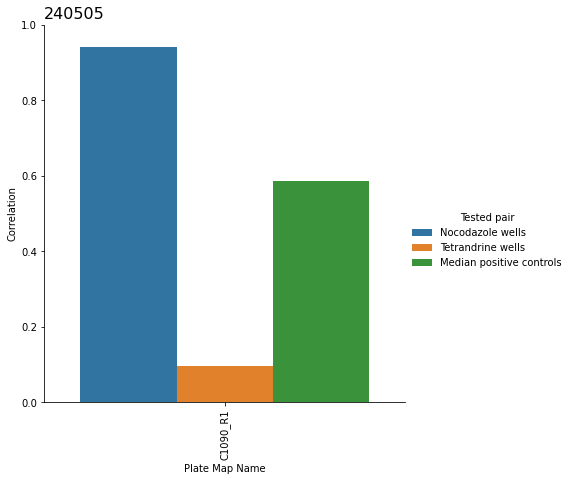

<Figure size 1008x504 with 0 Axes>

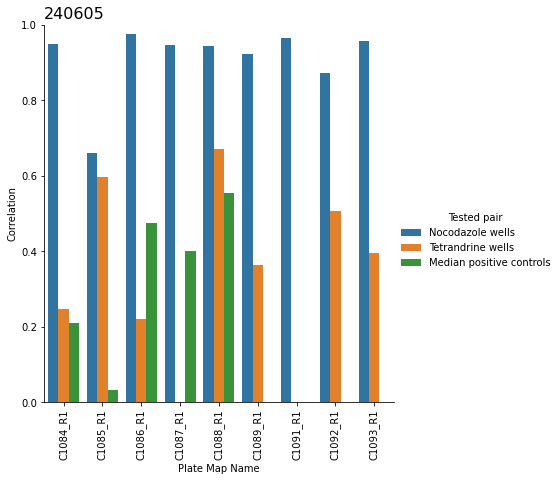

<Figure size 1008x504 with 0 Axes>

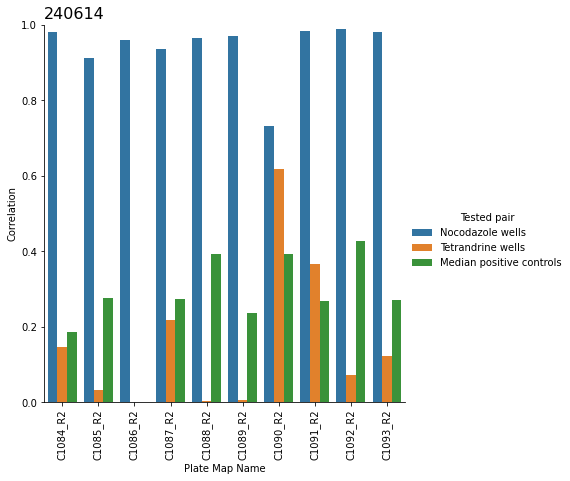

<Figure size 1008x504 with 0 Axes>

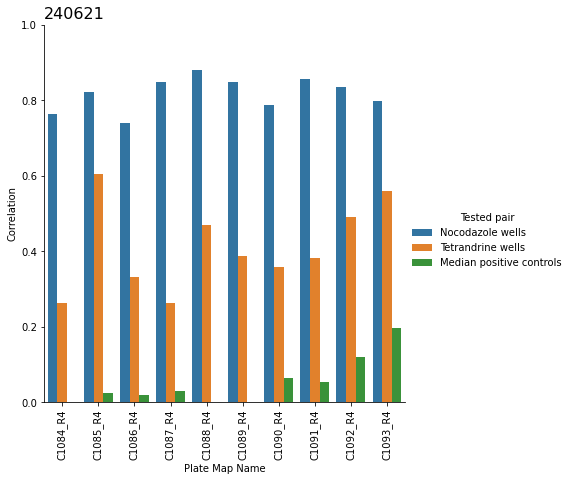

<Figure size 1008x504 with 0 Axes>

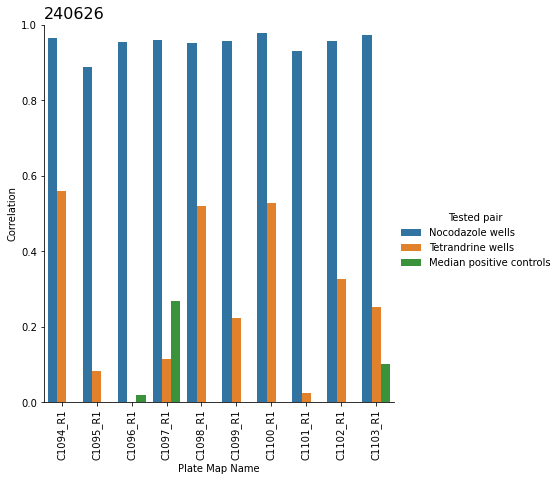

<Figure size 1008x504 with 0 Axes>

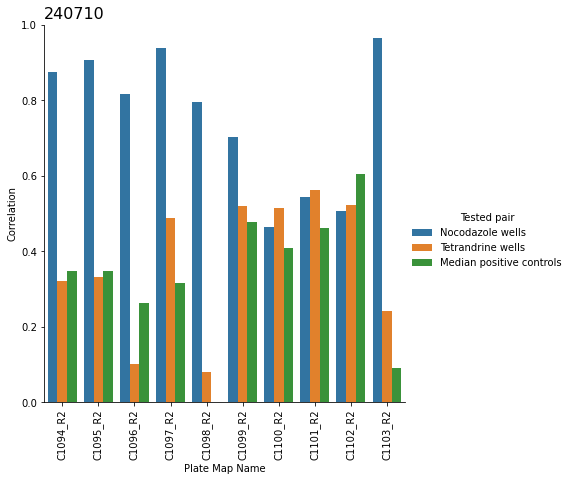

<Figure size 1008x504 with 0 Axes>

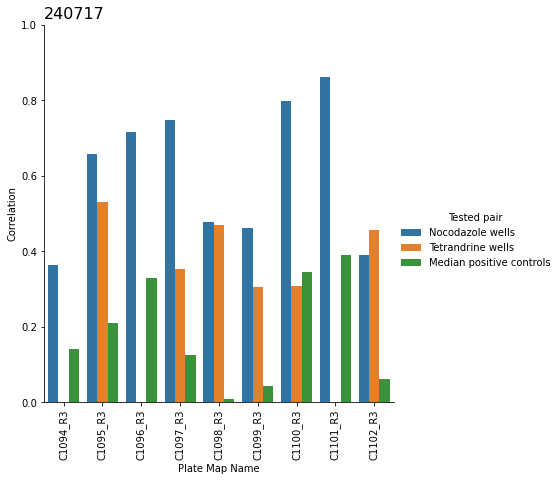

<Figure size 1008x504 with 0 Axes>

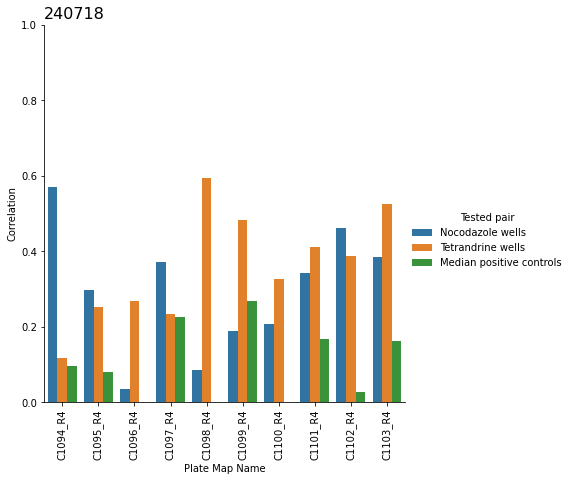

<Figure size 1008x504 with 0 Axes>

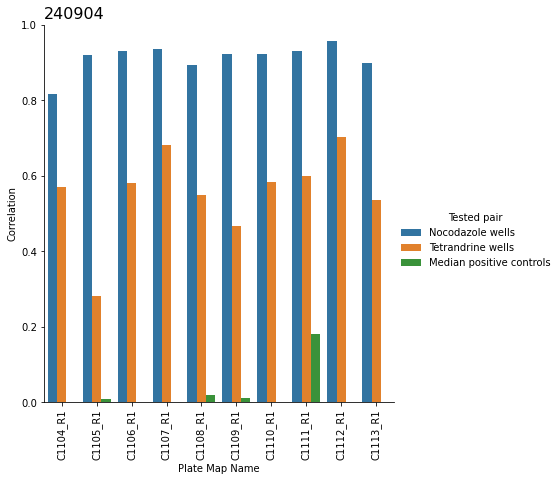

<Figure size 1008x504 with 0 Axes>

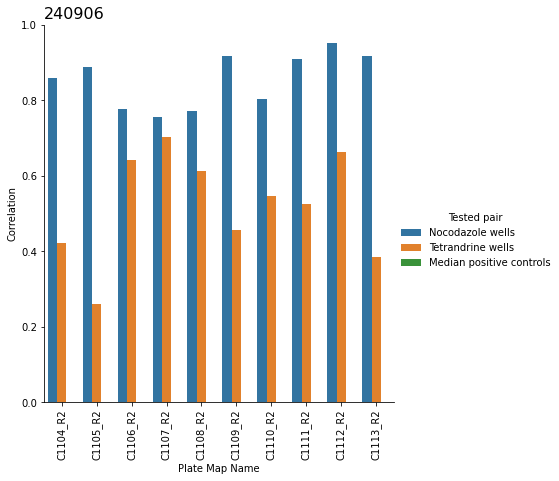

<Figure size 1008x504 with 0 Axes>

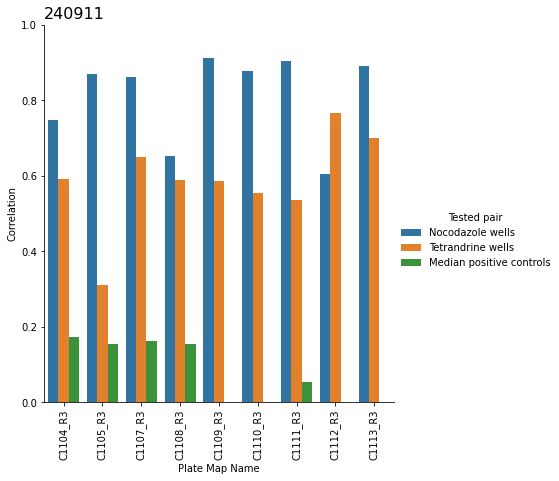

<Figure size 1008x504 with 0 Axes>

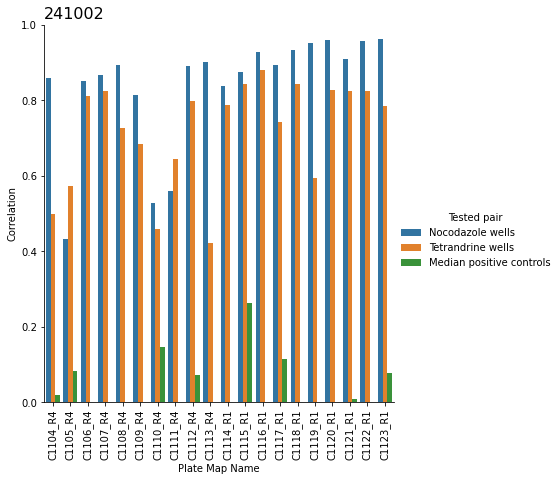

<Figure size 1008x504 with 0 Axes>

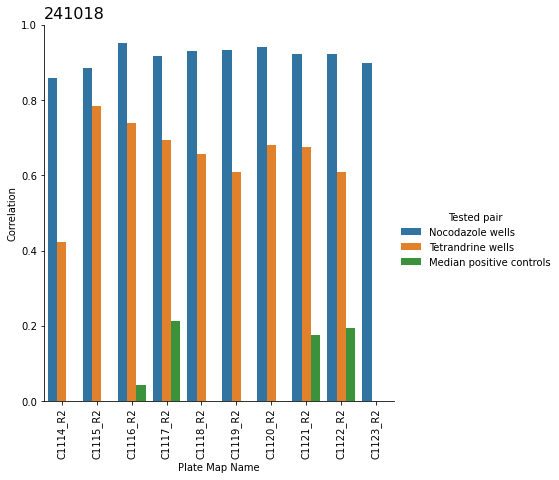

<Figure size 1008x504 with 0 Axes>

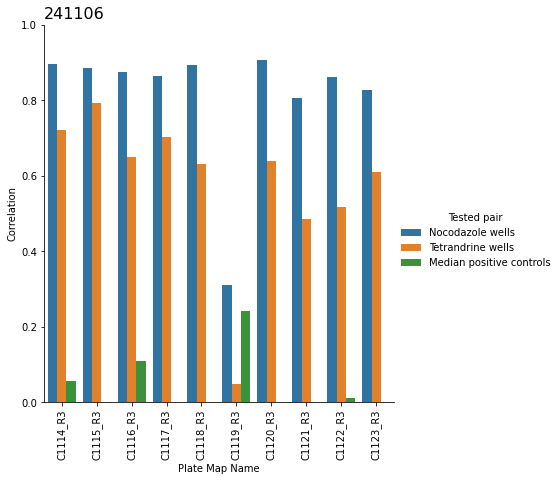

<Figure size 1008x504 with 0 Axes>

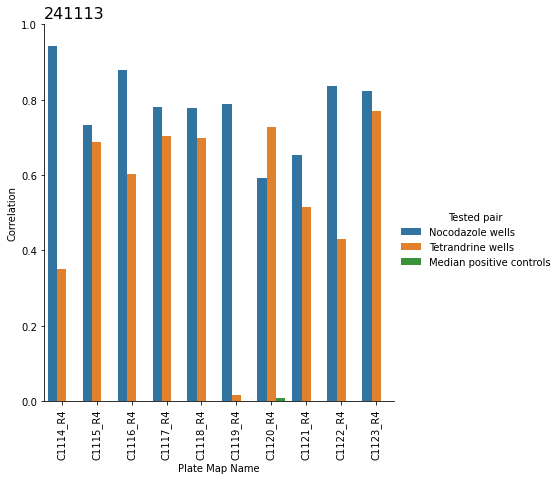

<Figure size 1008x504 with 0 Axes>

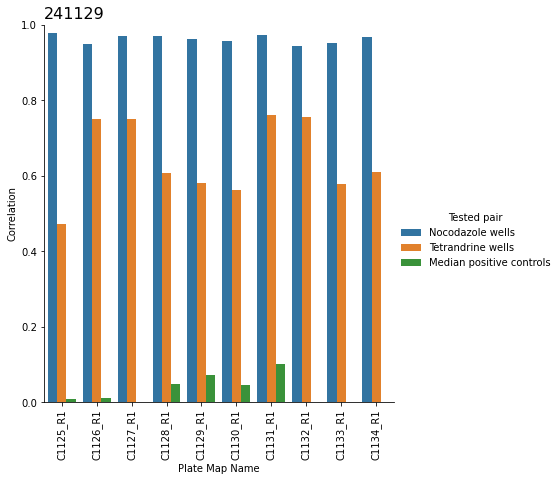

<Figure size 1008x504 with 0 Axes>

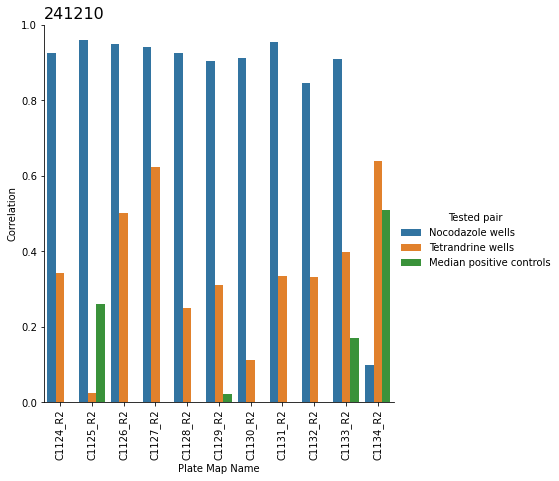

<Figure size 1008x504 with 0 Axes>

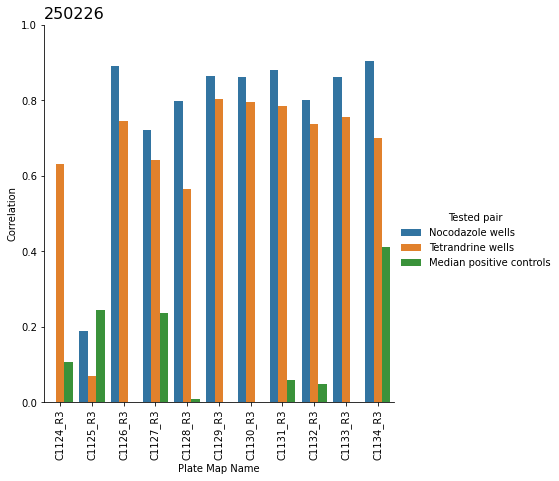

<Figure size 1008x504 with 0 Axes>

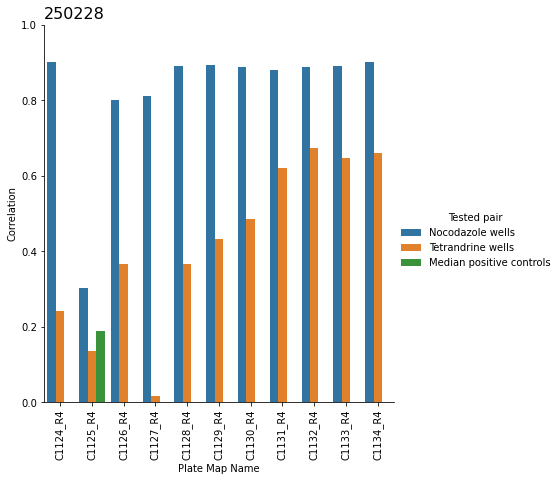

In [15]:
intra_plate_qc(quality_control_1_melt, 'FMP', figure_path)

<ipython-input-14-0656948dc2df>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 7))


<Figure size 1008x504 with 0 Axes>

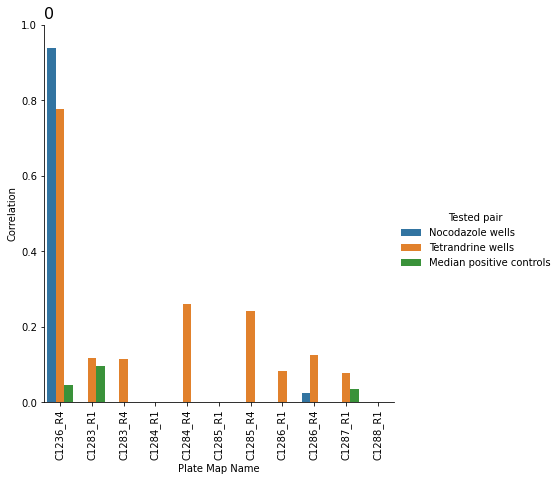

<Figure size 1008x504 with 0 Axes>

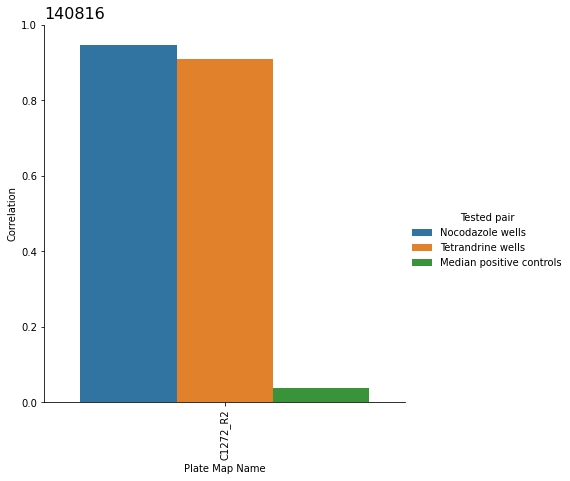

<Figure size 1008x504 with 0 Axes>

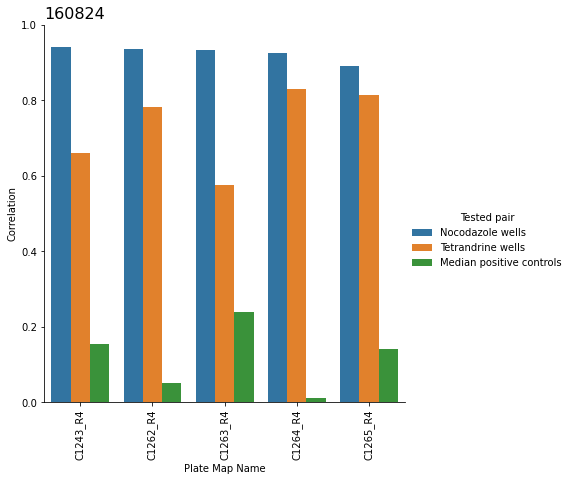

<Figure size 1008x504 with 0 Axes>

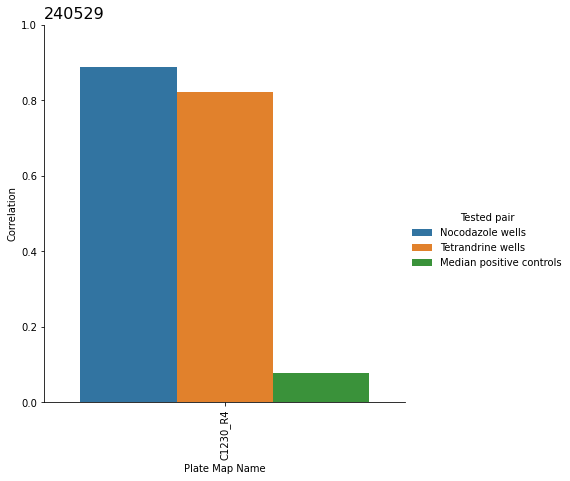

<Figure size 1008x504 with 0 Axes>

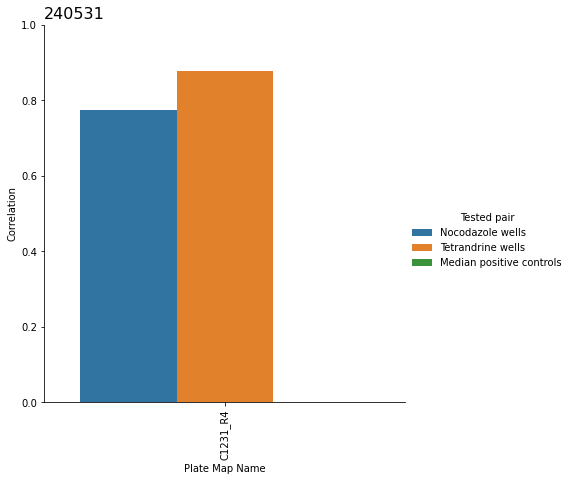

<Figure size 1008x504 with 0 Axes>

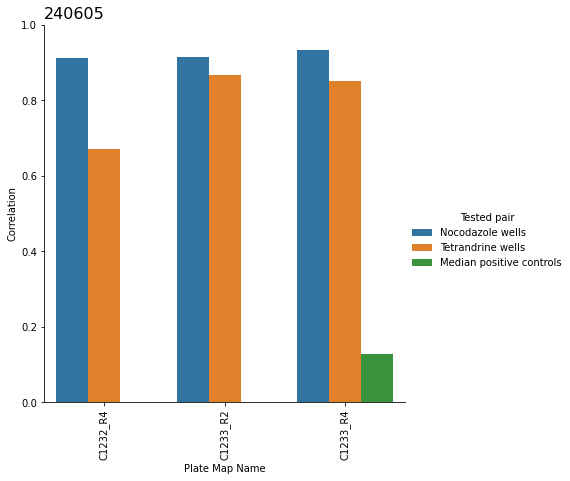

<Figure size 1008x504 with 0 Axes>

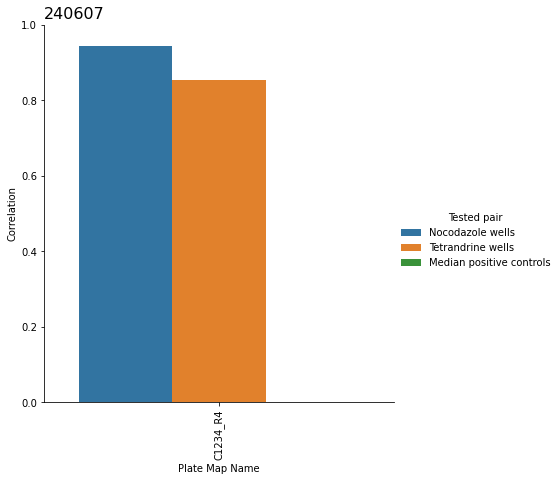

<Figure size 1008x504 with 0 Axes>

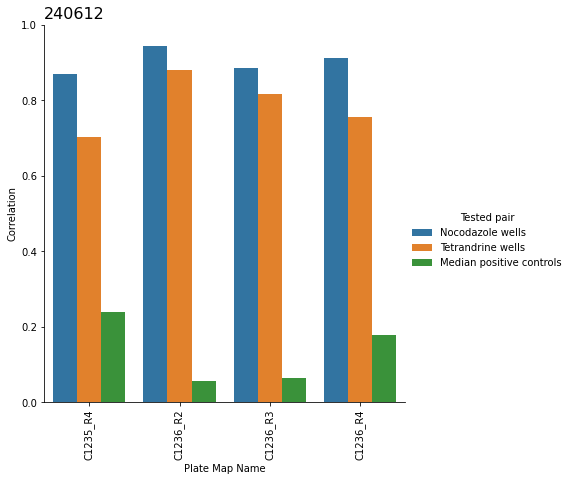

<Figure size 1008x504 with 0 Axes>

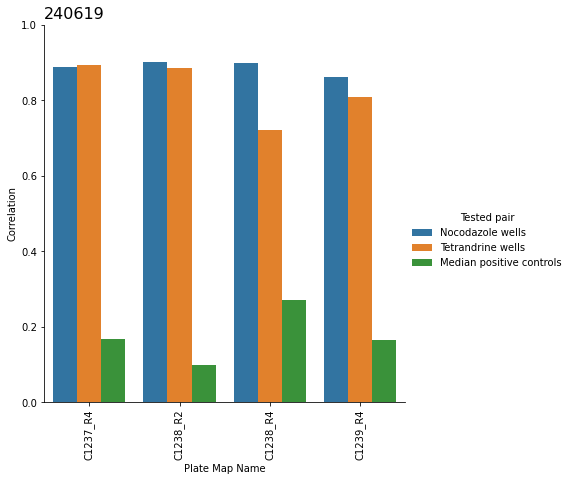

<Figure size 1008x504 with 0 Axes>

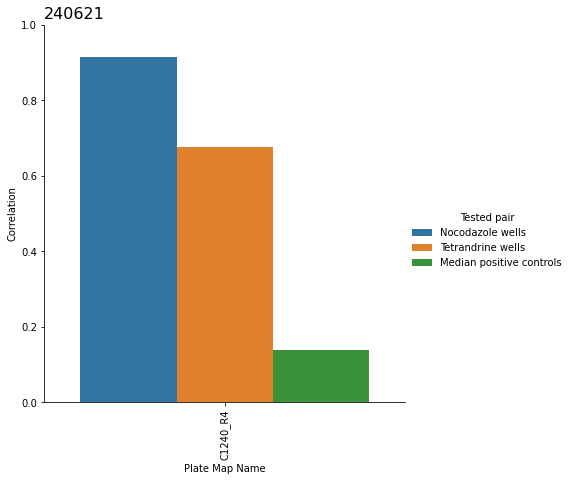

<Figure size 1008x504 with 0 Axes>

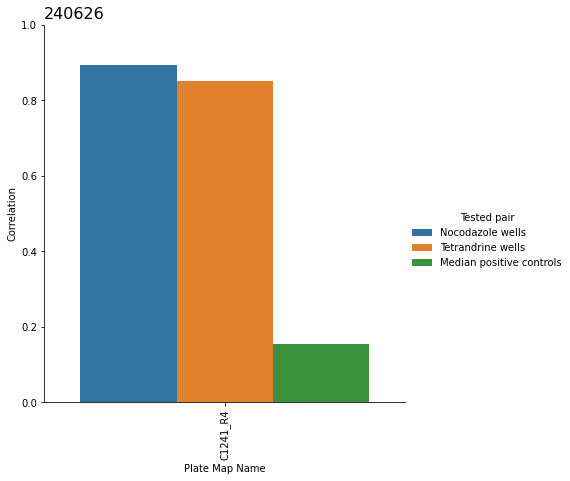

<Figure size 1008x504 with 0 Axes>

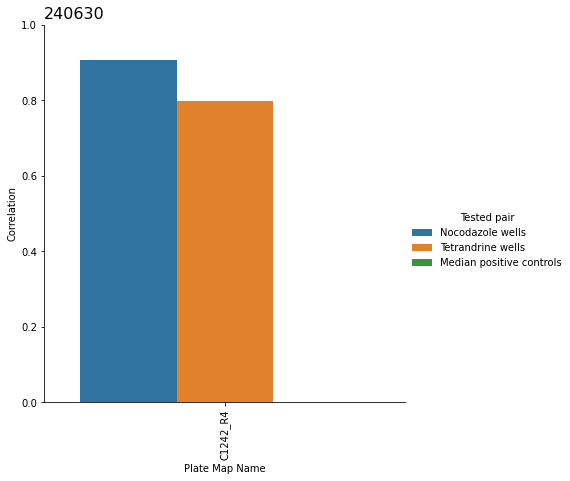

<Figure size 1008x504 with 0 Axes>

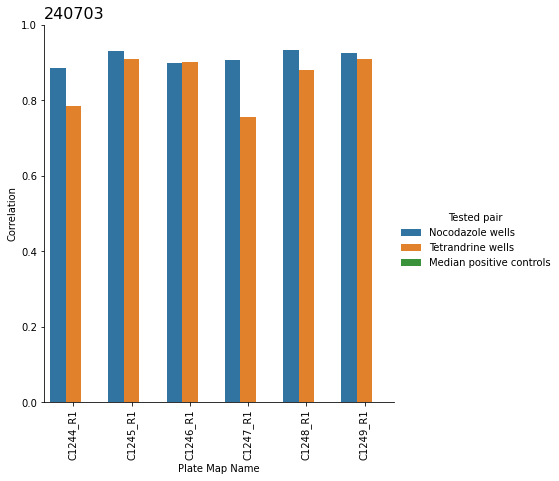

<Figure size 1008x504 with 0 Axes>

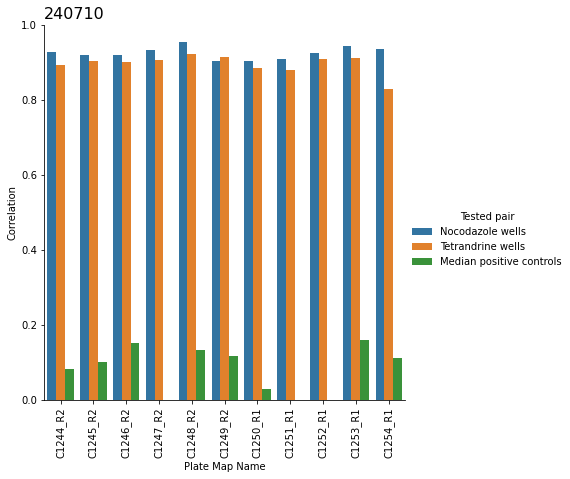

<Figure size 1008x504 with 0 Axes>

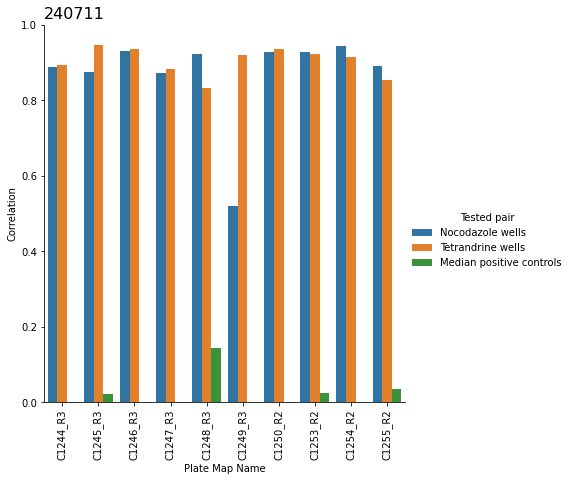

<Figure size 1008x504 with 0 Axes>

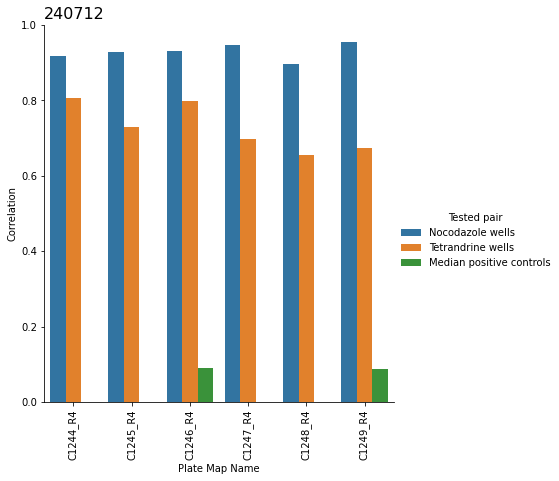

<Figure size 1008x504 with 0 Axes>

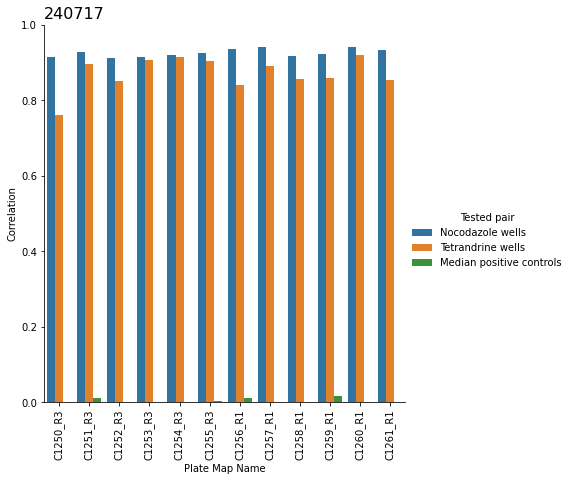

<Figure size 1008x504 with 0 Axes>

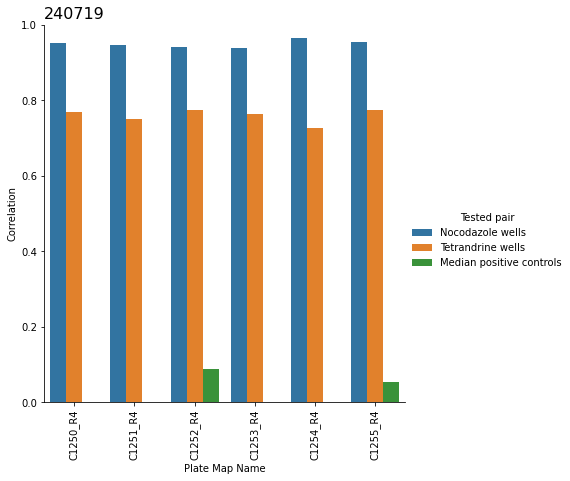

<Figure size 1008x504 with 0 Axes>

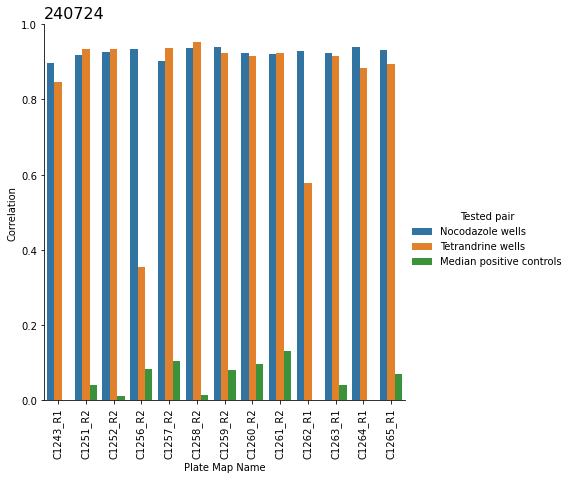

<Figure size 1008x504 with 0 Axes>

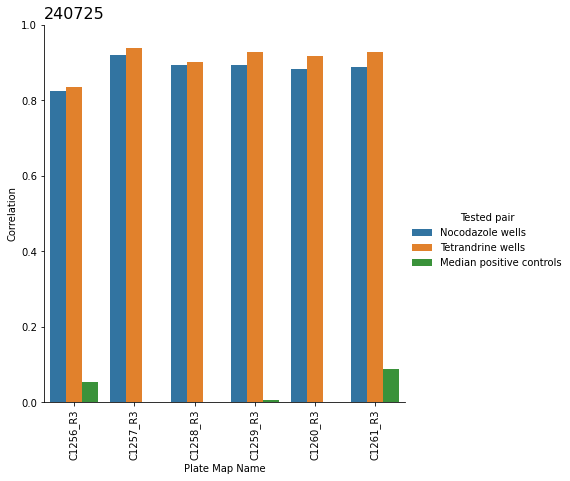

<Figure size 1008x504 with 0 Axes>

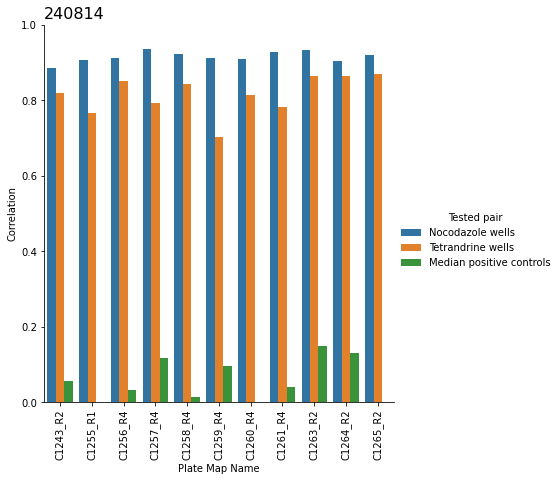

<Figure size 1008x504 with 0 Axes>

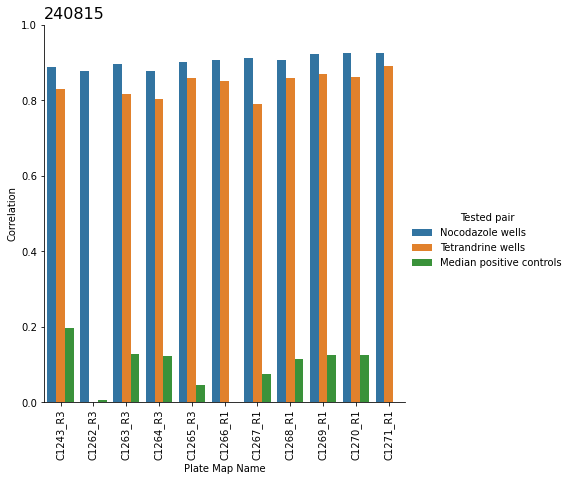

<Figure size 1008x504 with 0 Axes>

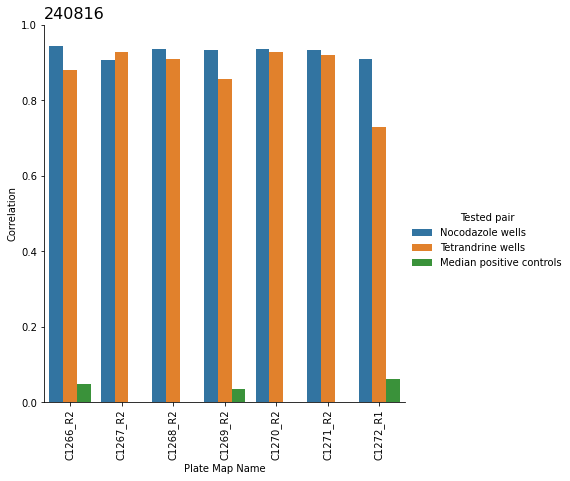

<Figure size 1008x504 with 0 Axes>

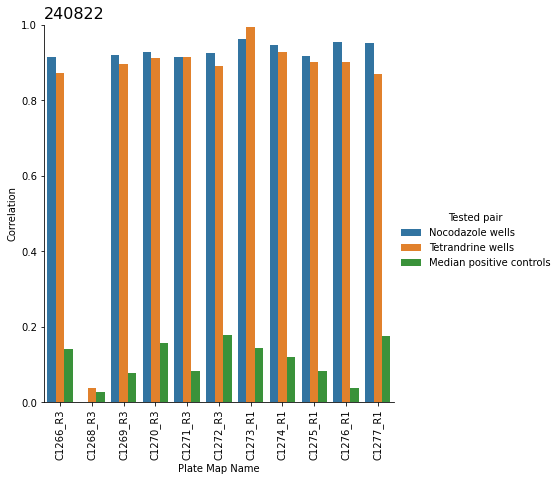

<Figure size 1008x504 with 0 Axes>

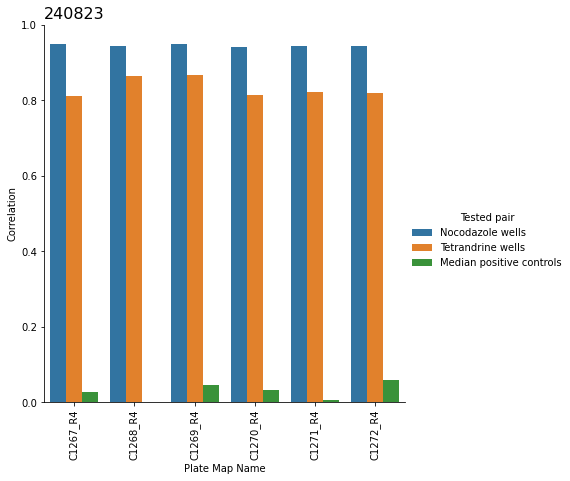

<Figure size 1008x504 with 0 Axes>

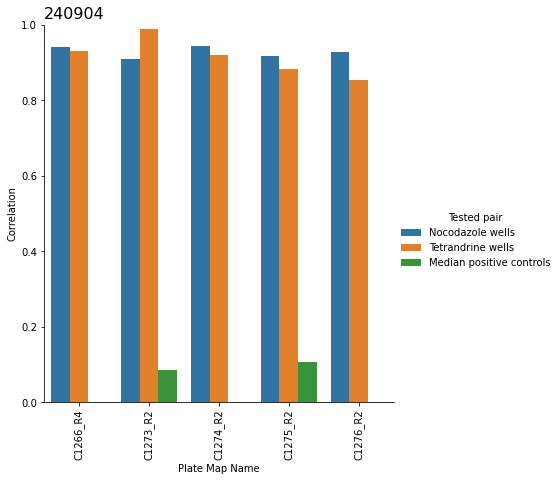

<Figure size 1008x504 with 0 Axes>

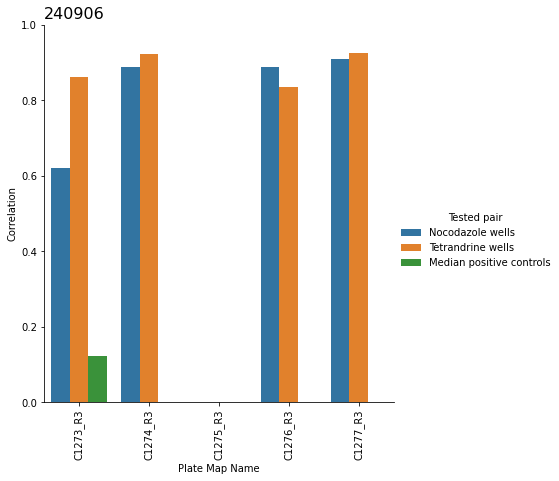

<Figure size 1008x504 with 0 Axes>

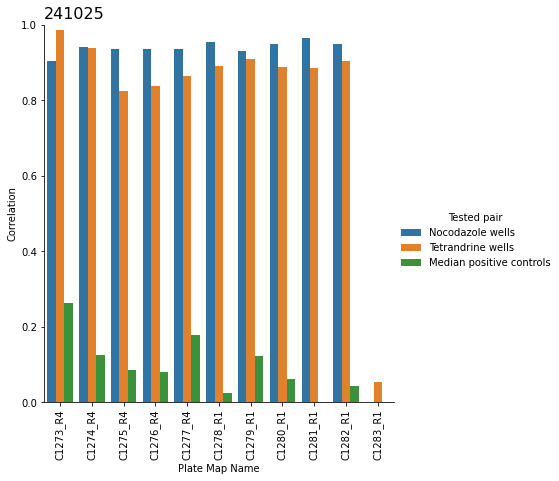

<Figure size 1008x504 with 0 Axes>

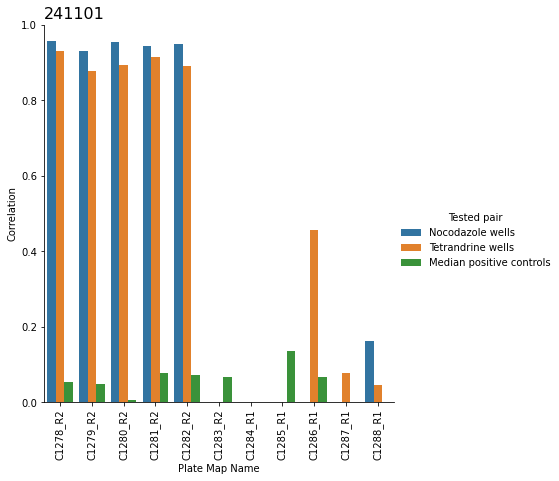

<Figure size 1008x504 with 0 Axes>

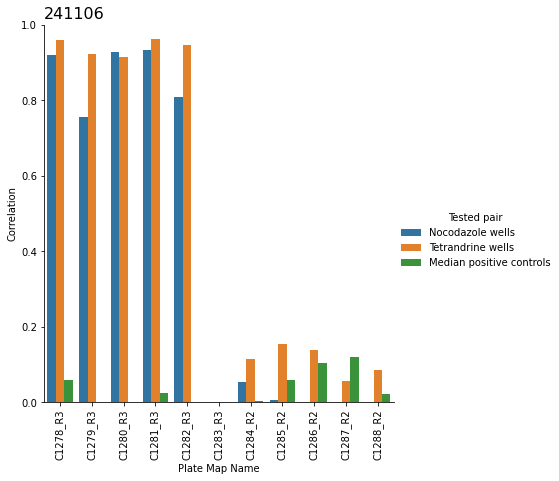

<Figure size 1008x504 with 0 Axes>

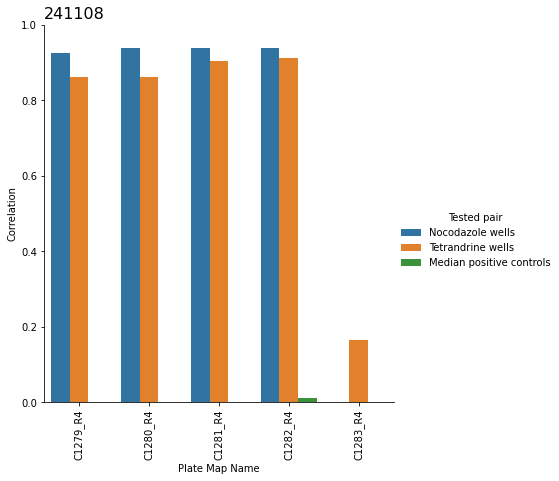

<Figure size 1008x504 with 0 Axes>

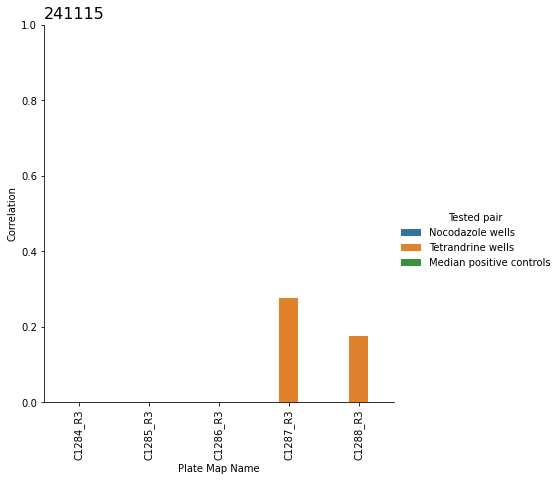

<Figure size 1008x504 with 0 Axes>

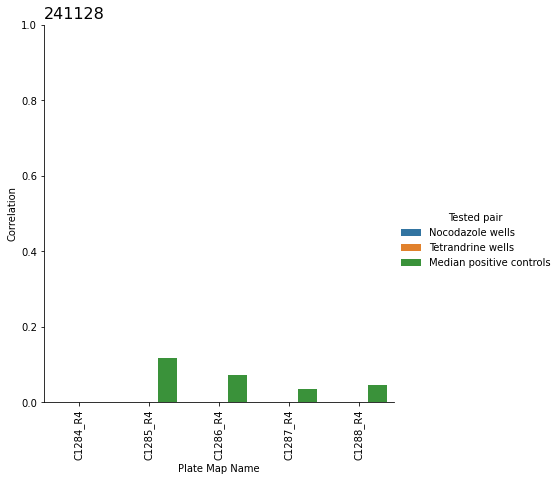

<Figure size 1008x504 with 0 Axes>

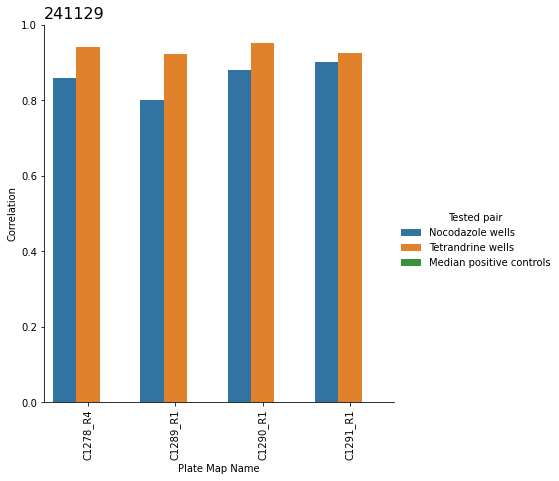

<Figure size 1008x504 with 0 Axes>

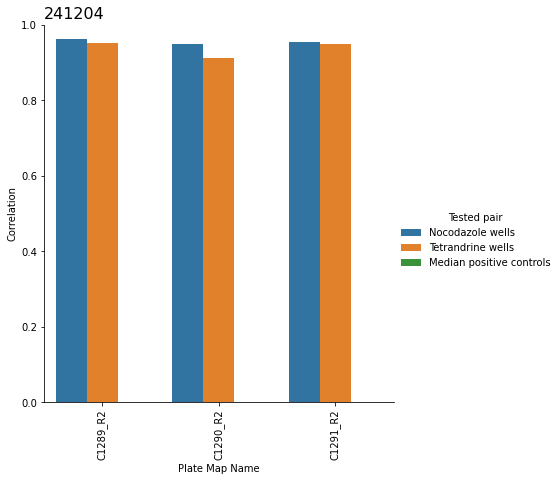

<Figure size 1008x504 with 0 Axes>

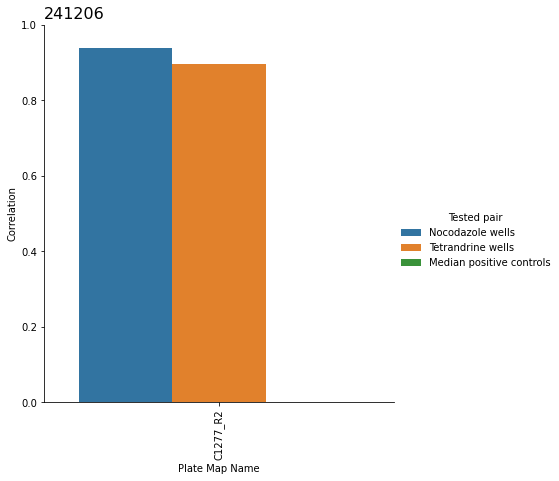

<Figure size 1008x504 with 0 Axes>

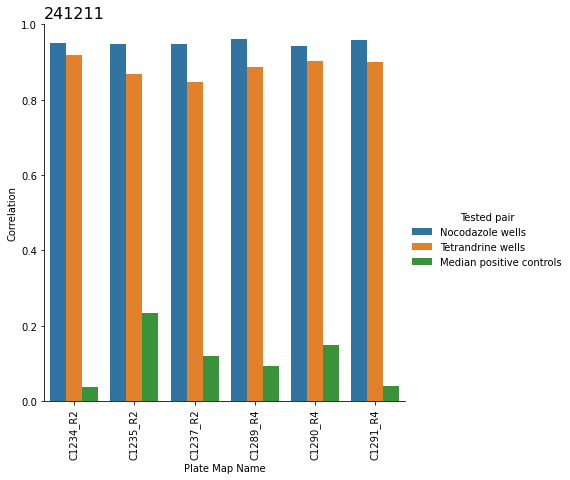

<Figure size 1008x504 with 0 Axes>

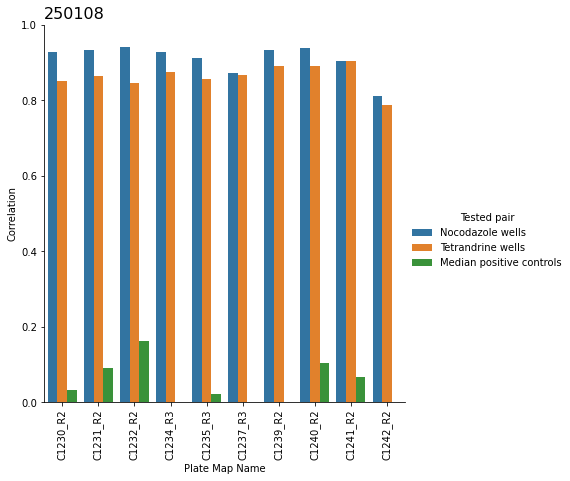

<Figure size 1008x504 with 0 Axes>

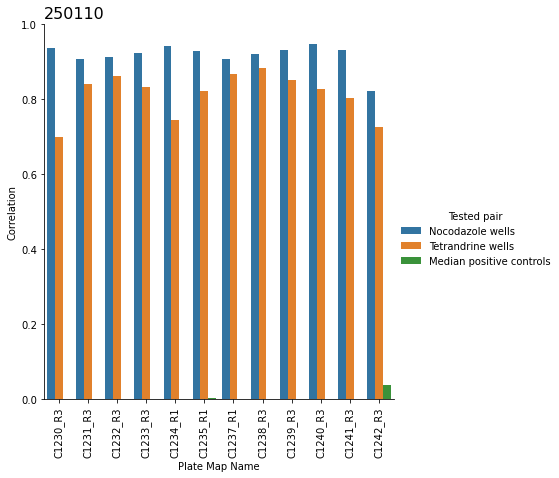

<Figure size 1008x504 with 0 Axes>

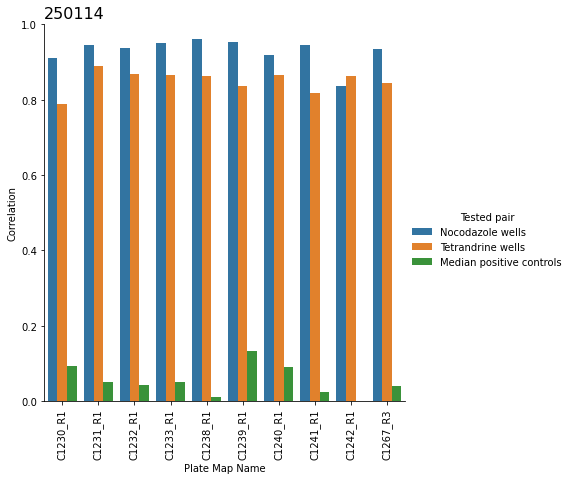

<Figure size 1008x504 with 0 Axes>

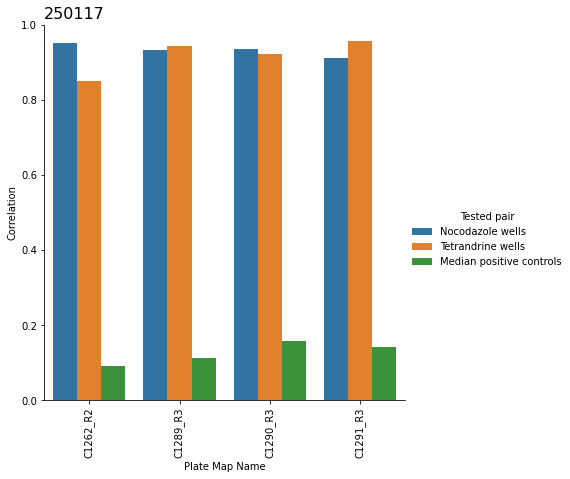

<Figure size 1008x504 with 0 Axes>

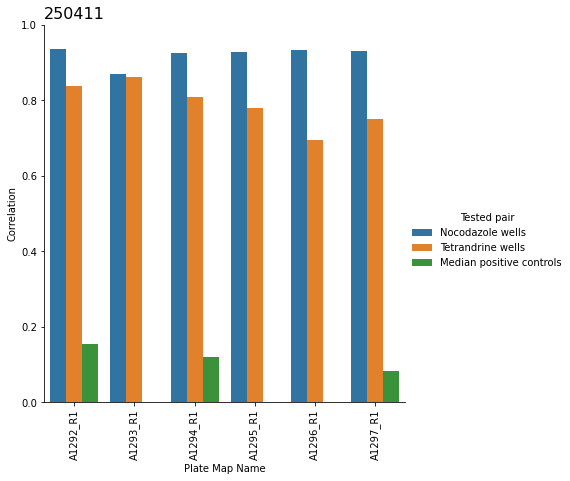

<Figure size 1008x504 with 0 Axes>

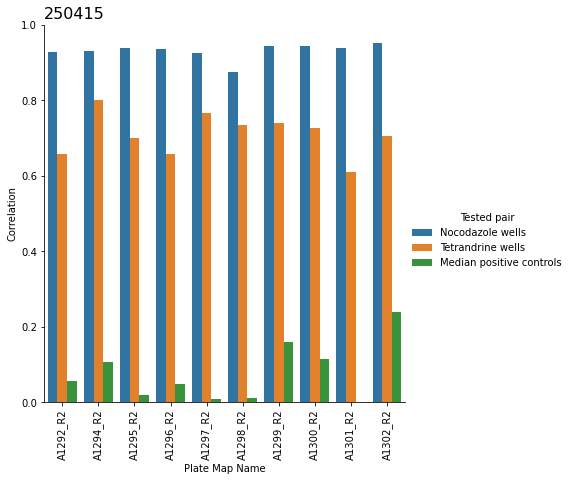

<Figure size 1008x504 with 0 Axes>

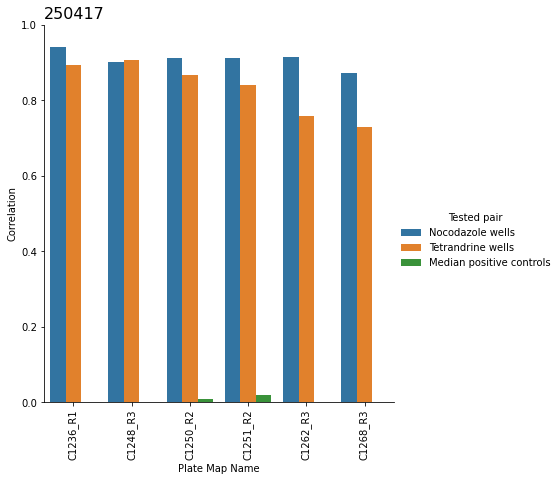

<Figure size 1008x504 with 0 Axes>

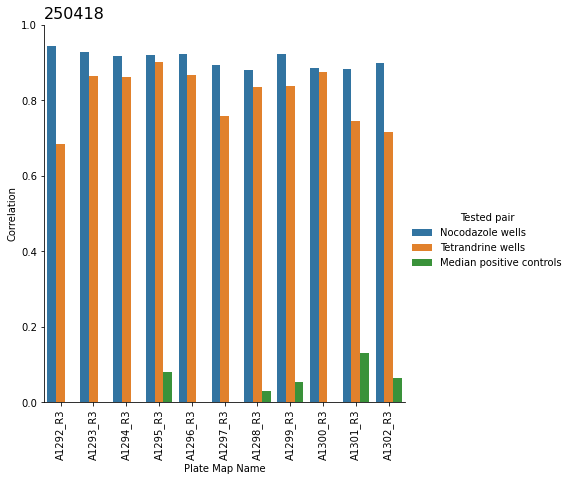

<Figure size 1008x504 with 0 Axes>

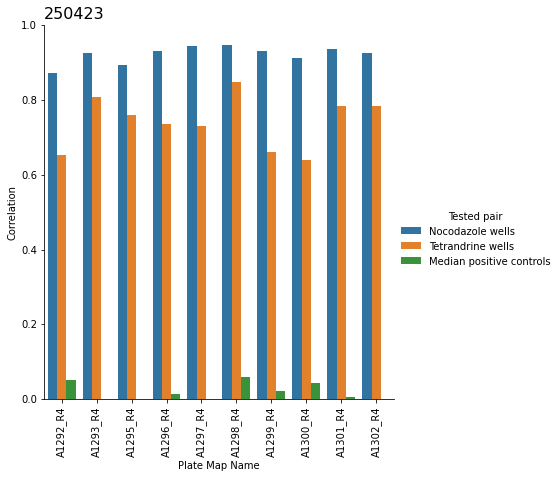

<Figure size 1008x504 with 0 Axes>

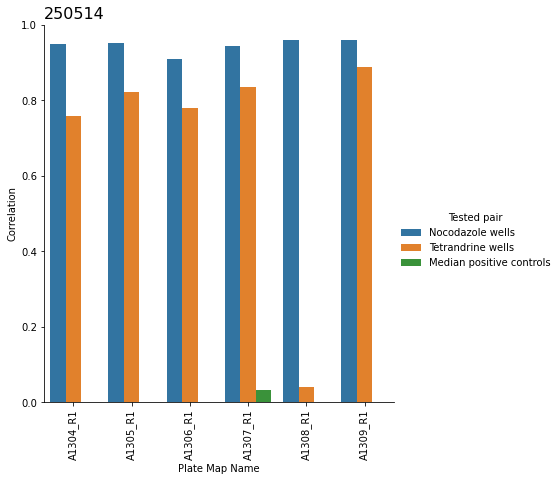

<Figure size 1008x504 with 0 Axes>

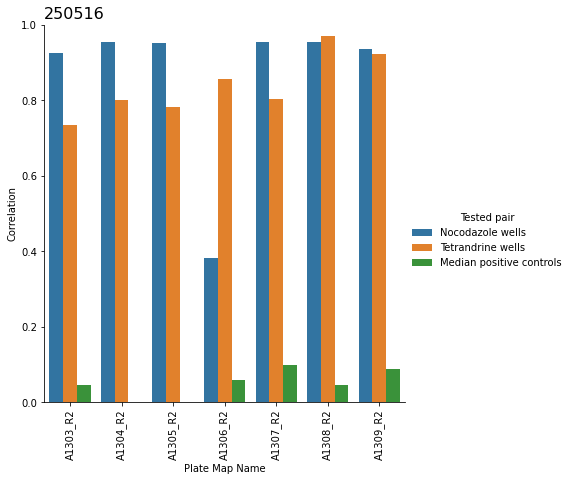

<Figure size 1008x504 with 0 Axes>

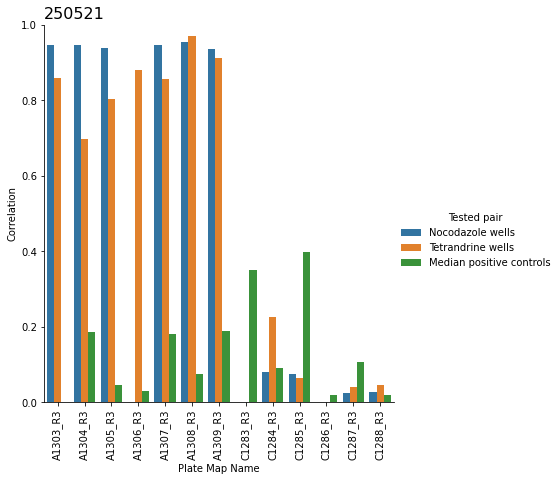

<Figure size 1008x504 with 0 Axes>

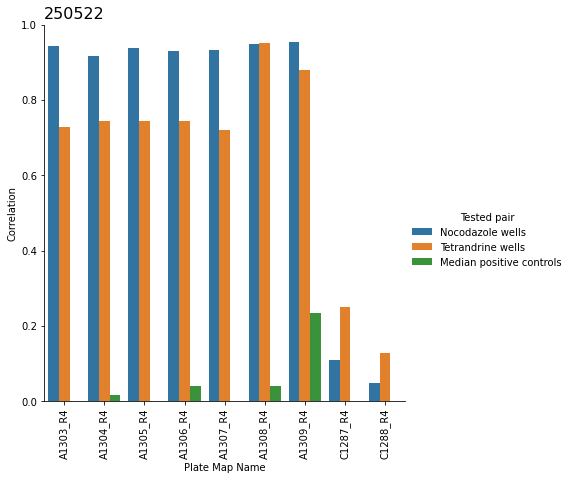

<Figure size 1008x504 with 0 Axes>

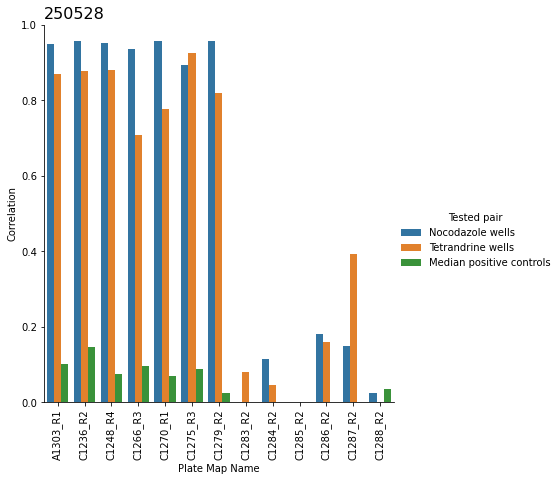

In [16]:
intra_plate_qc(quality_control_1_melt, 'IMTM', figure_path)

<ipython-input-14-0656948dc2df>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 7))


<Figure size 1008x504 with 0 Axes>

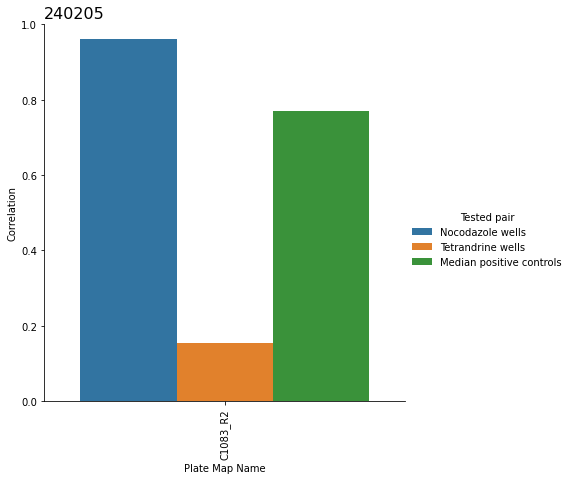

<Figure size 1008x504 with 0 Axes>

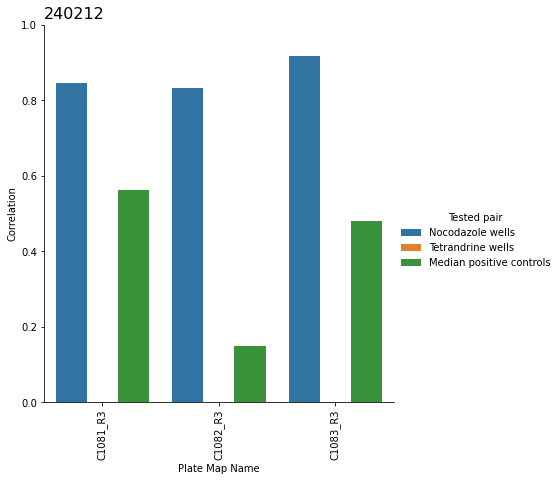

<Figure size 1008x504 with 0 Axes>

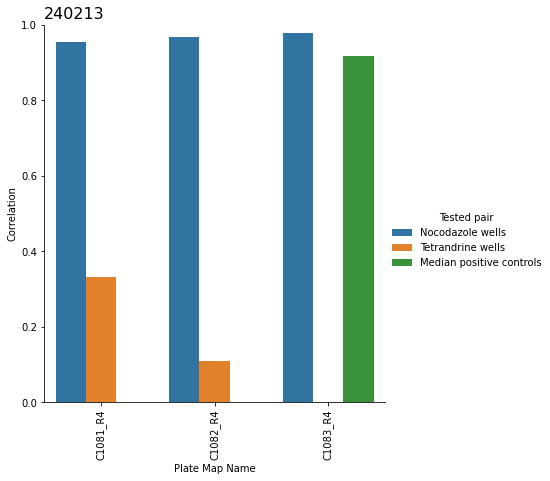

<Figure size 1008x504 with 0 Axes>

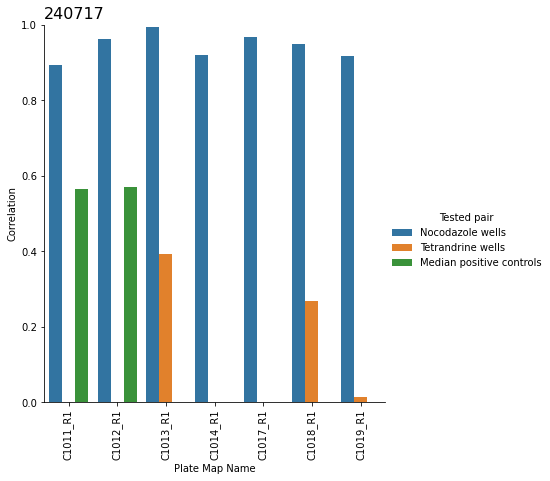

<Figure size 1008x504 with 0 Axes>

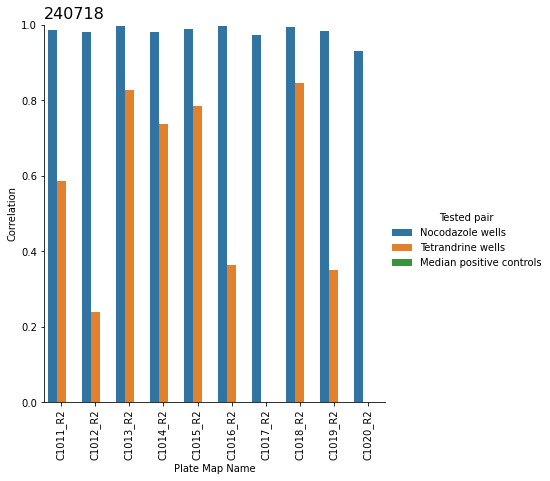

<Figure size 1008x504 with 0 Axes>

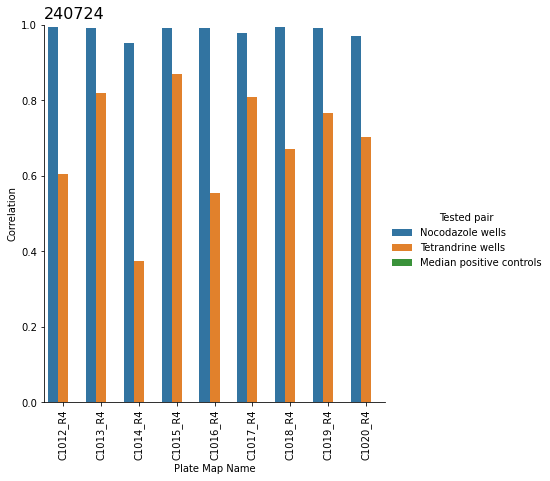

<Figure size 1008x504 with 0 Axes>

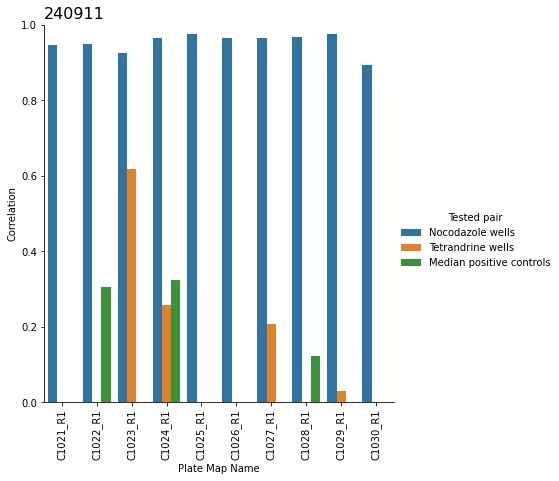

<Figure size 1008x504 with 0 Axes>

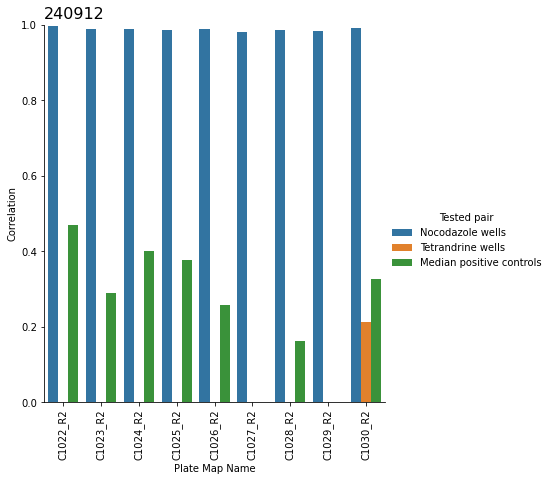

<Figure size 1008x504 with 0 Axes>

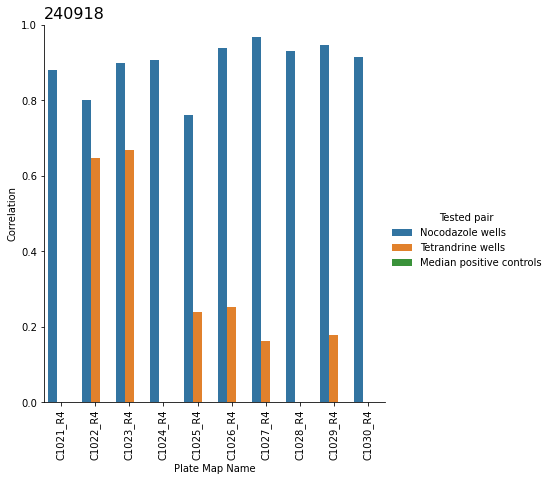

<Figure size 1008x504 with 0 Axes>

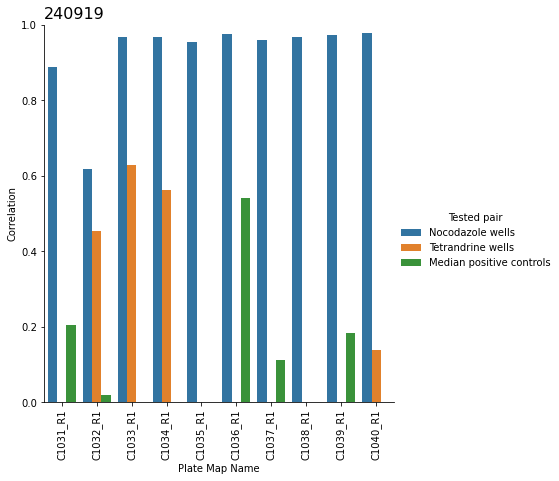

<Figure size 1008x504 with 0 Axes>

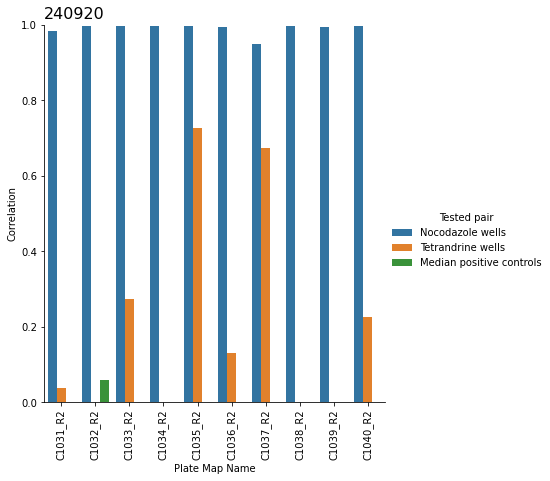

<Figure size 1008x504 with 0 Axes>

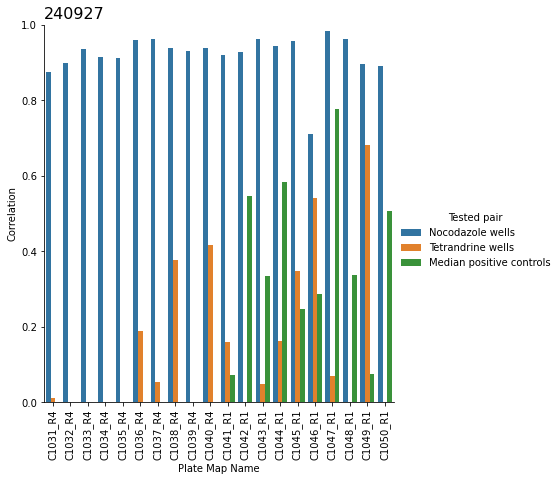

<Figure size 1008x504 with 0 Axes>

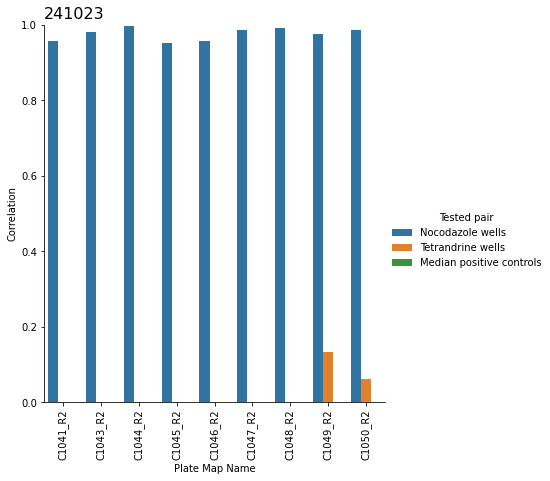

<Figure size 1008x504 with 0 Axes>

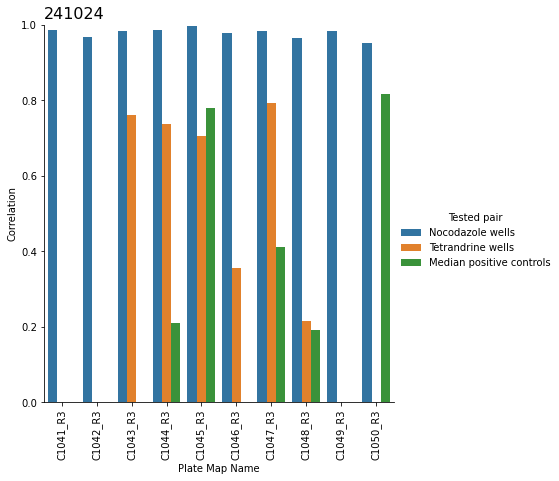

<Figure size 1008x504 with 0 Axes>

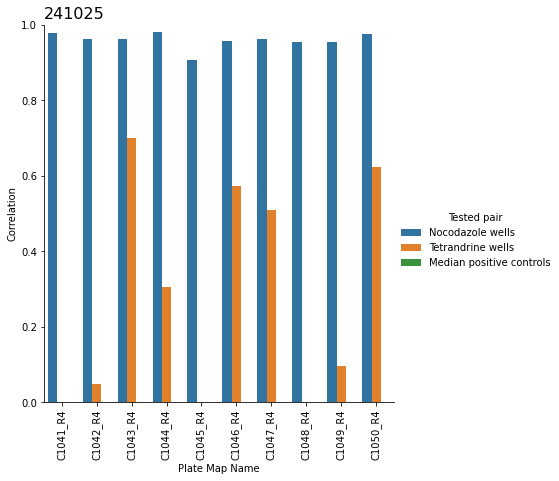

<Figure size 1008x504 with 0 Axes>

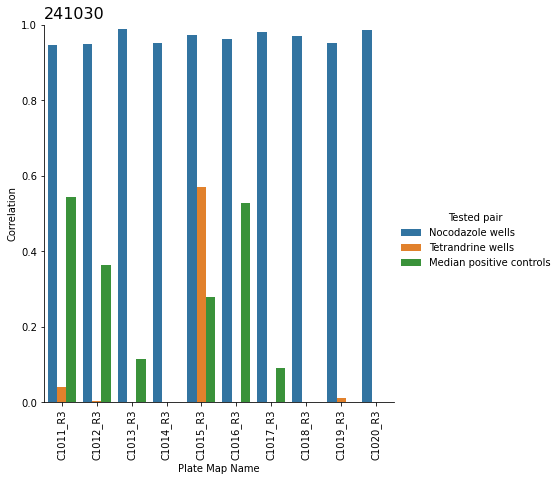

<Figure size 1008x504 with 0 Axes>

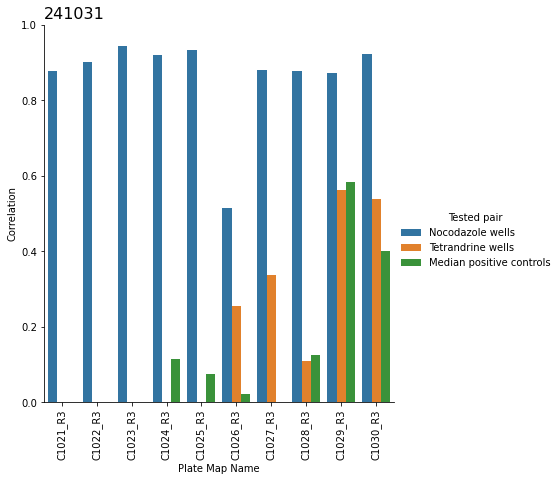

<Figure size 1008x504 with 0 Axes>

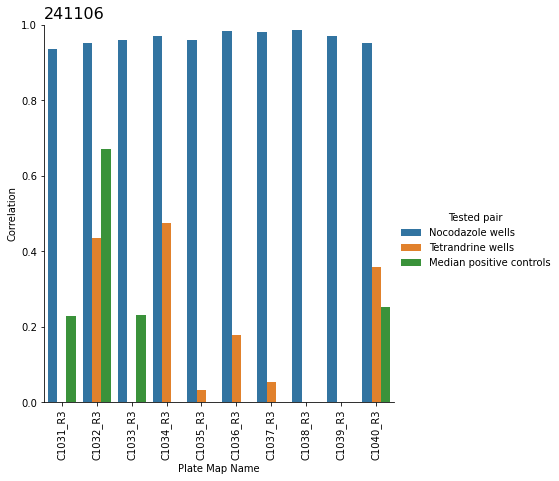

<Figure size 1008x504 with 0 Axes>

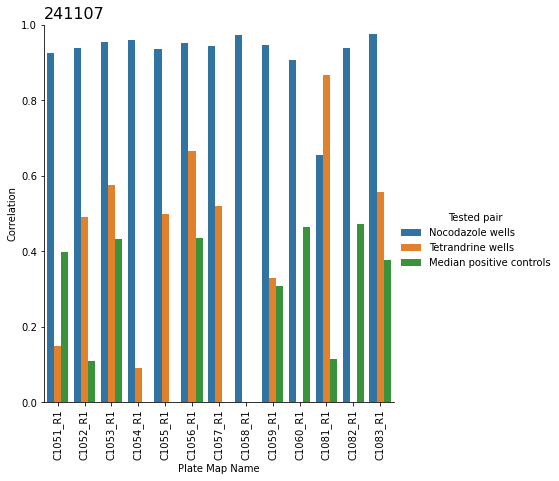

<Figure size 1008x504 with 0 Axes>

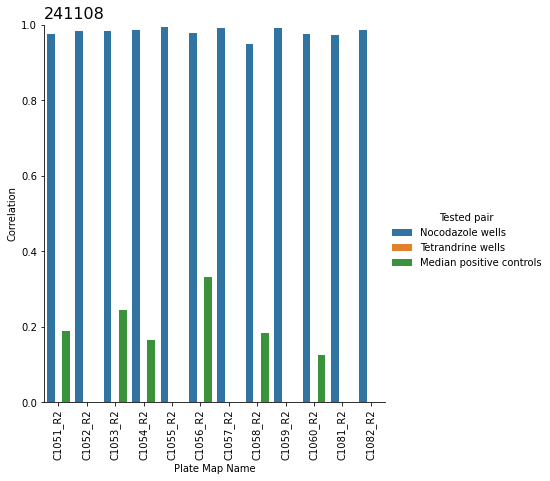

<Figure size 1008x504 with 0 Axes>

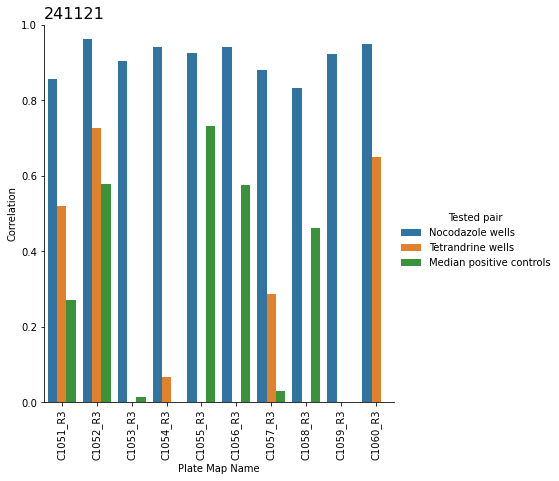

<Figure size 1008x504 with 0 Axes>

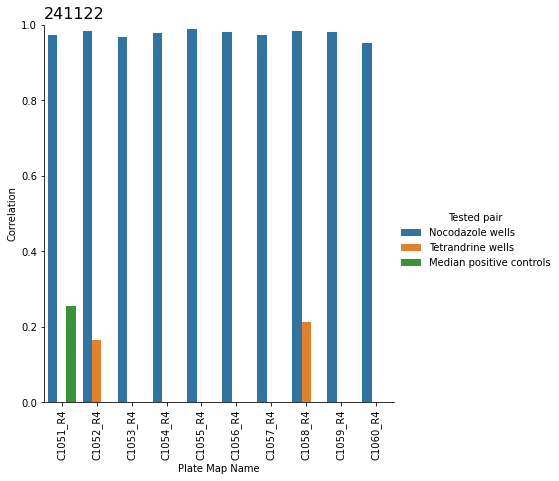

<Figure size 1008x504 with 0 Axes>

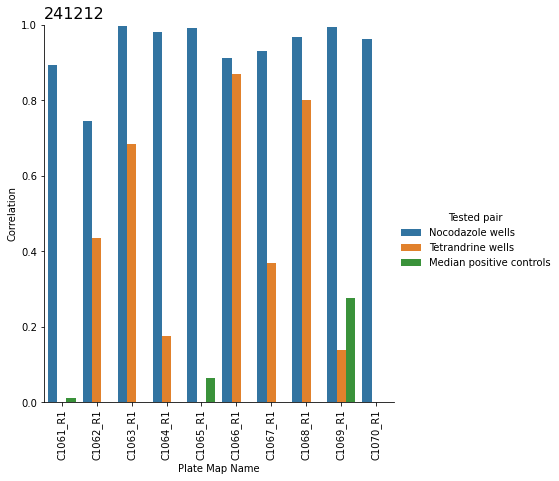

<Figure size 1008x504 with 0 Axes>

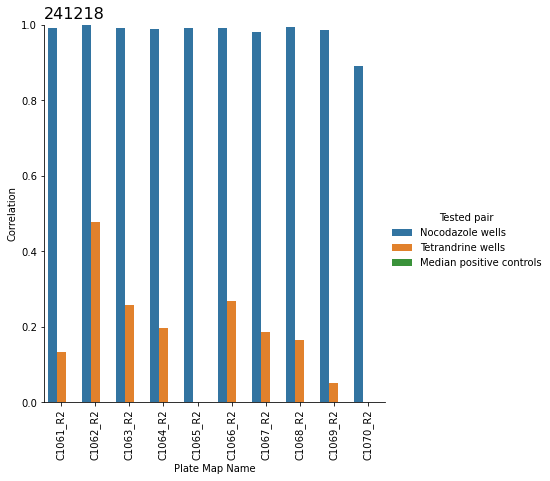

<Figure size 1008x504 with 0 Axes>

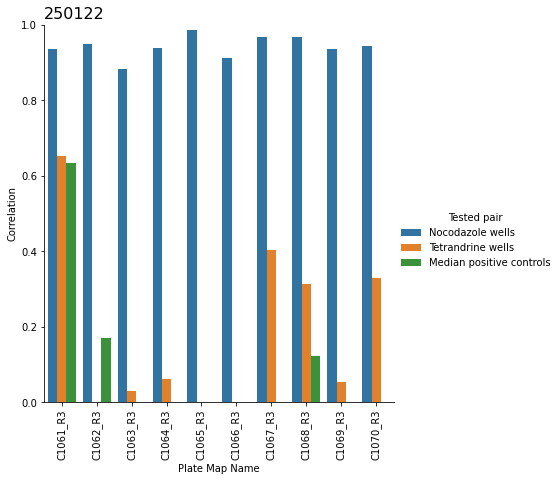

<Figure size 1008x504 with 0 Axes>

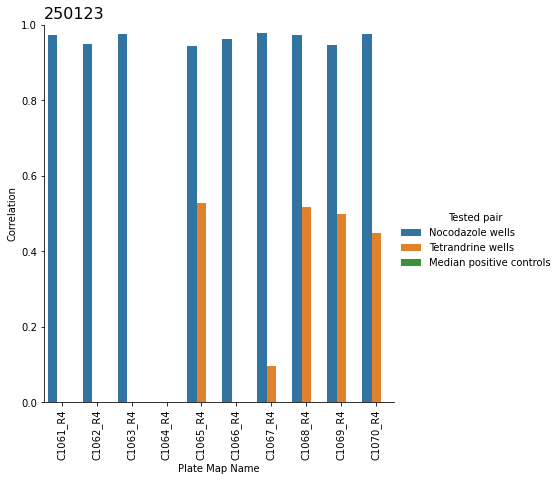

<Figure size 1008x504 with 0 Axes>

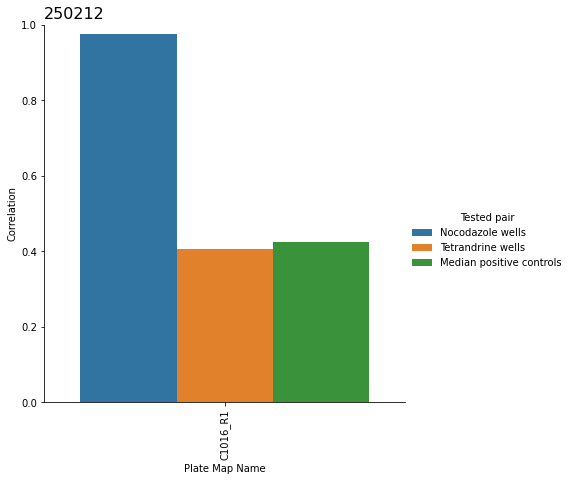

<Figure size 1008x504 with 0 Axes>

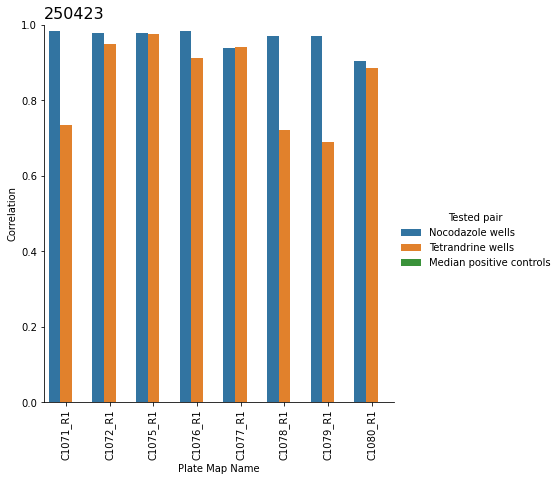

<Figure size 1008x504 with 0 Axes>

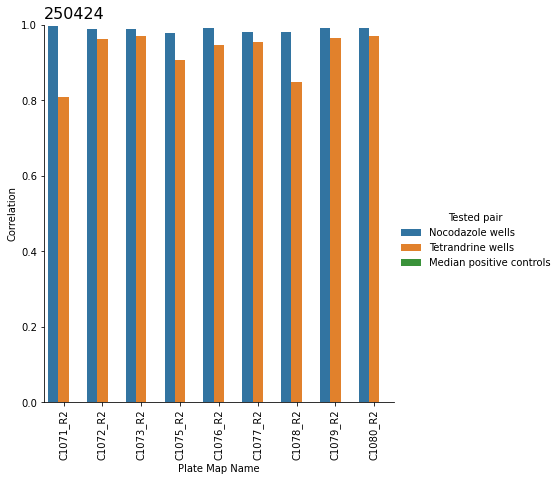

<Figure size 1008x504 with 0 Axes>

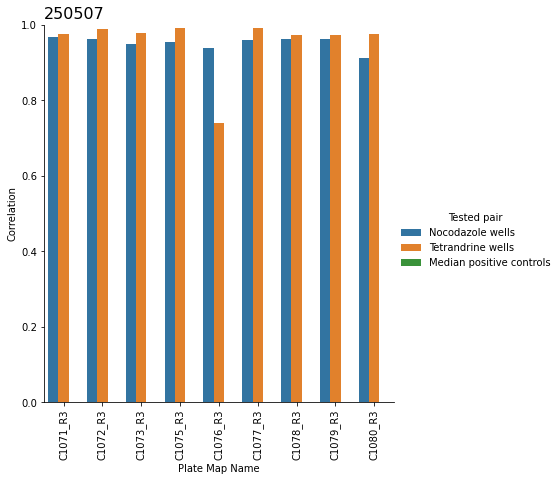

<Figure size 1008x504 with 0 Axes>

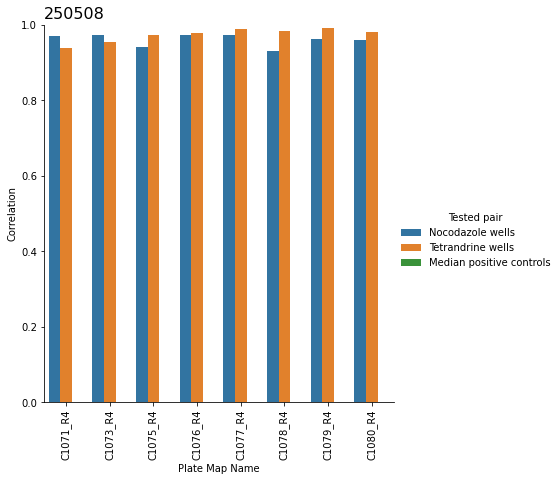

<Figure size 1008x504 with 0 Axes>

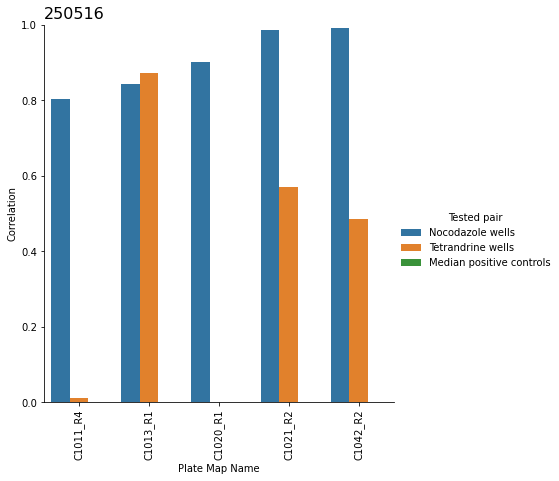

In [17]:
intra_plate_qc(quality_control_1_melt, 'MEDINA', figure_path)

<ipython-input-14-0656948dc2df>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 7))


<Figure size 1008x504 with 0 Axes>

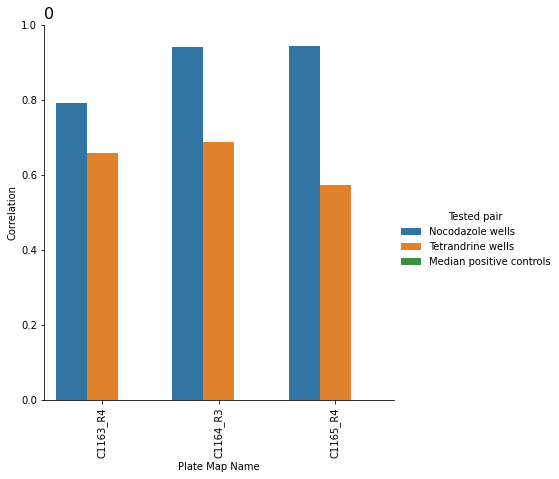

<Figure size 1008x504 with 0 Axes>

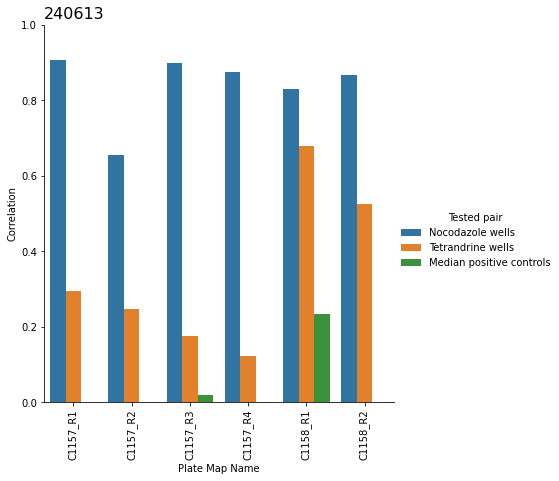

<Figure size 1008x504 with 0 Axes>

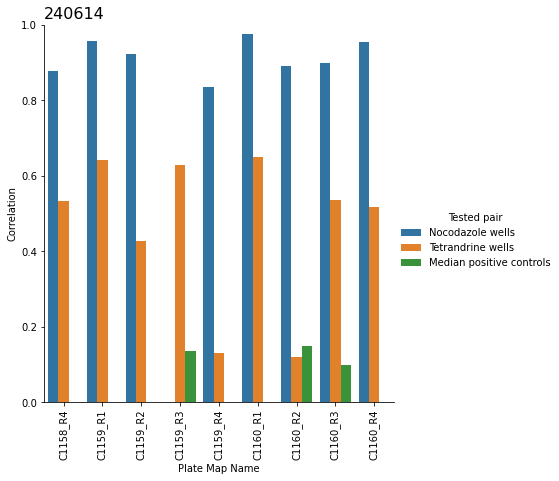

<Figure size 1008x504 with 0 Axes>

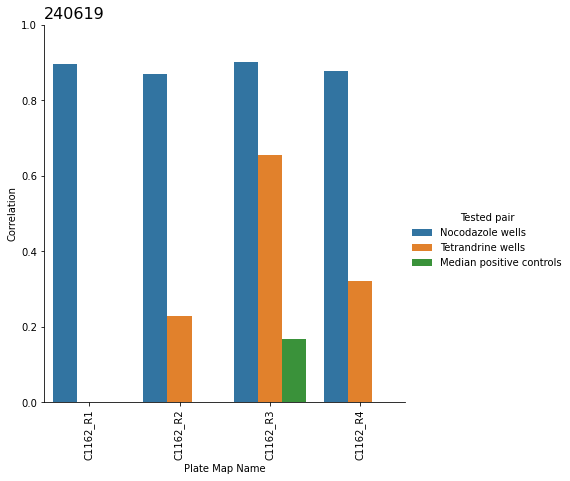

<Figure size 1008x504 with 0 Axes>

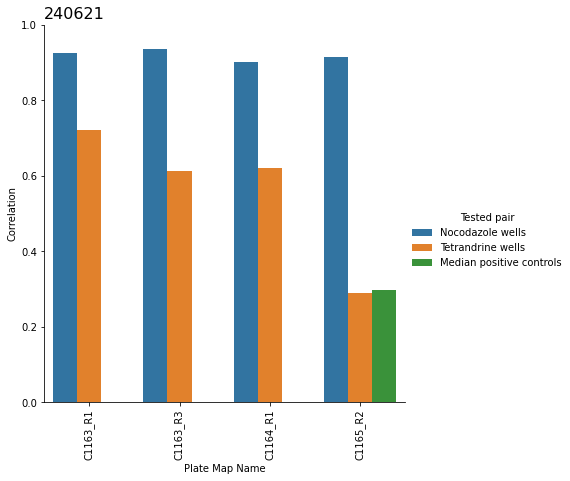

<Figure size 1008x504 with 0 Axes>

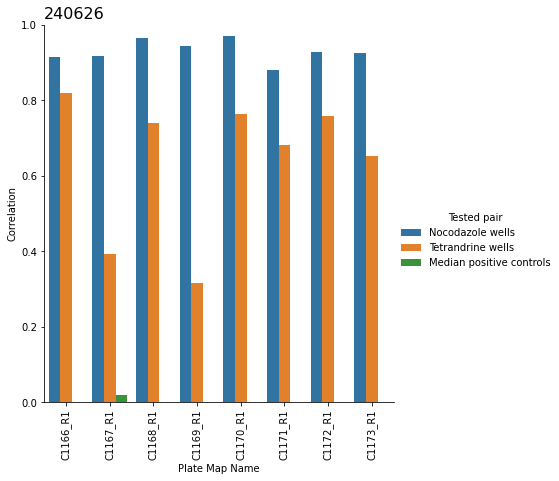

<Figure size 1008x504 with 0 Axes>

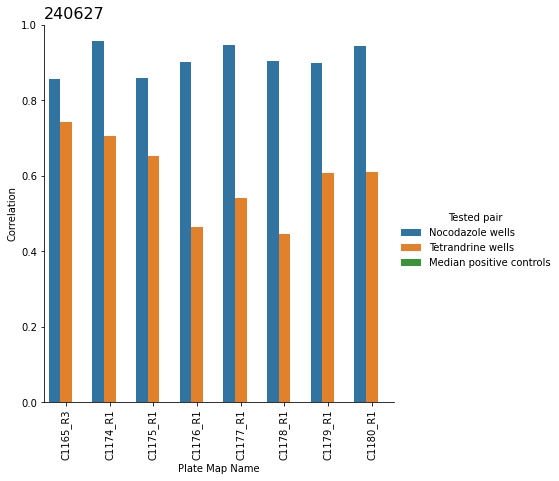

<Figure size 1008x504 with 0 Axes>

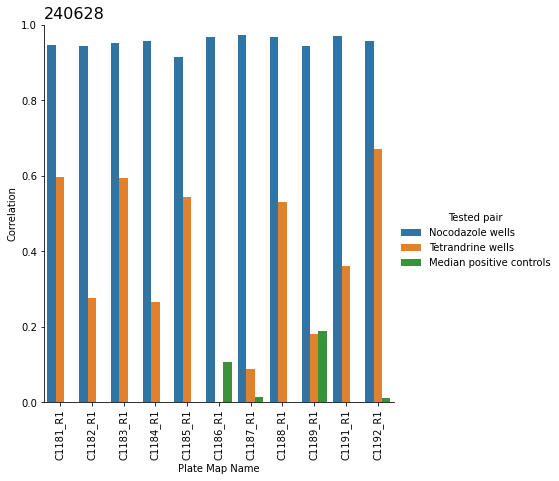

<Figure size 1008x504 with 0 Axes>

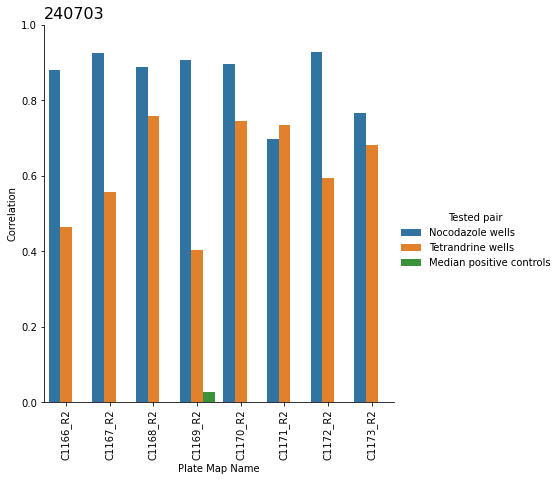

<Figure size 1008x504 with 0 Axes>

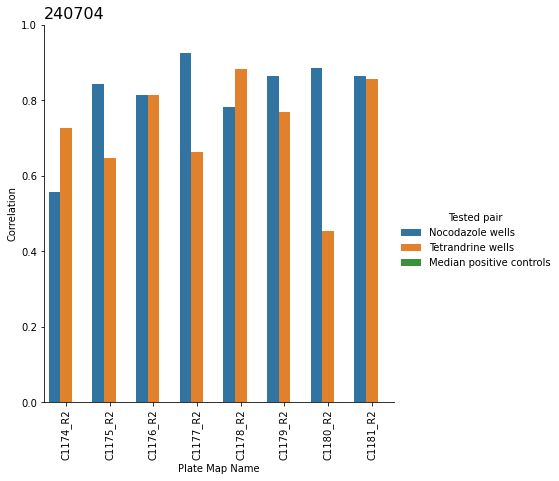

<Figure size 1008x504 with 0 Axes>

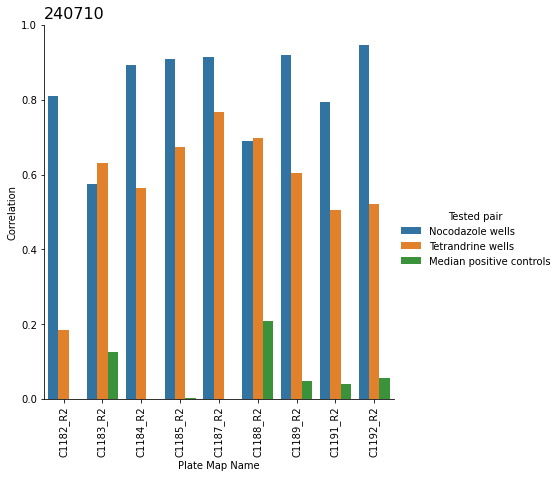

<Figure size 1008x504 with 0 Axes>

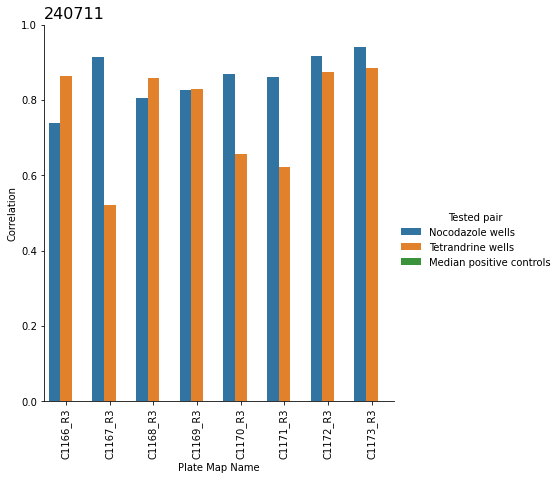

<Figure size 1008x504 with 0 Axes>

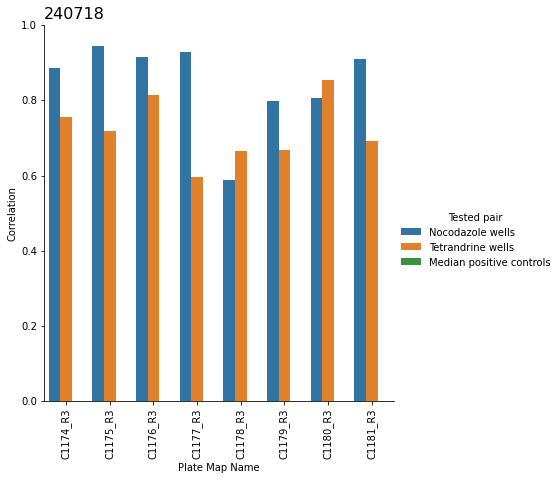

<Figure size 1008x504 with 0 Axes>

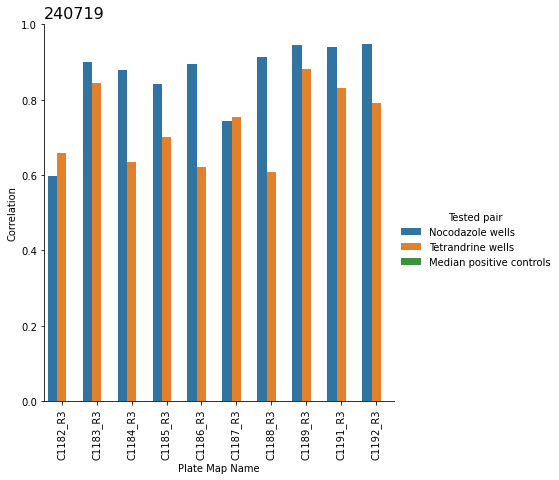

<Figure size 1008x504 with 0 Axes>

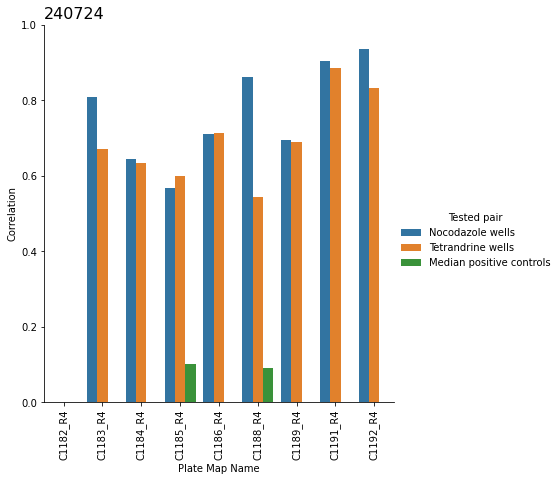

<Figure size 1008x504 with 0 Axes>

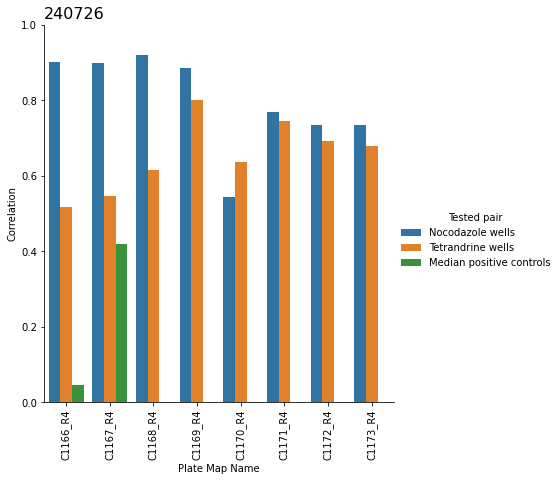

<Figure size 1008x504 with 0 Axes>

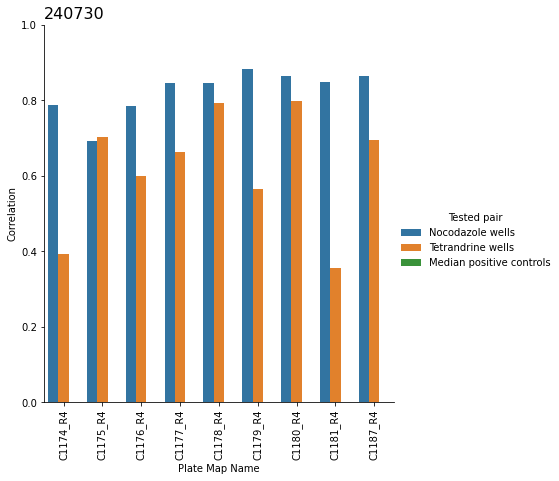

<Figure size 1008x504 with 0 Axes>

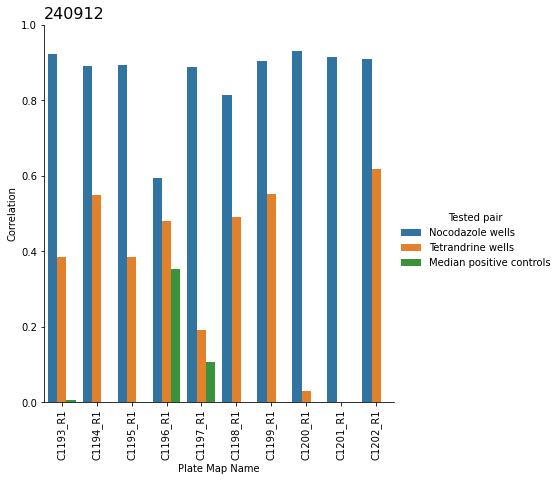

<Figure size 1008x504 with 0 Axes>

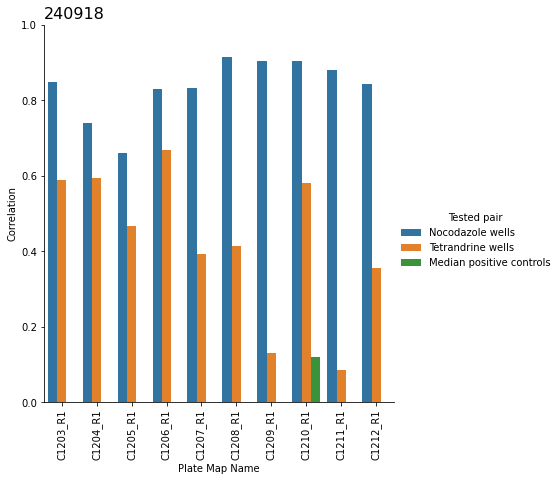

<Figure size 1008x504 with 0 Axes>

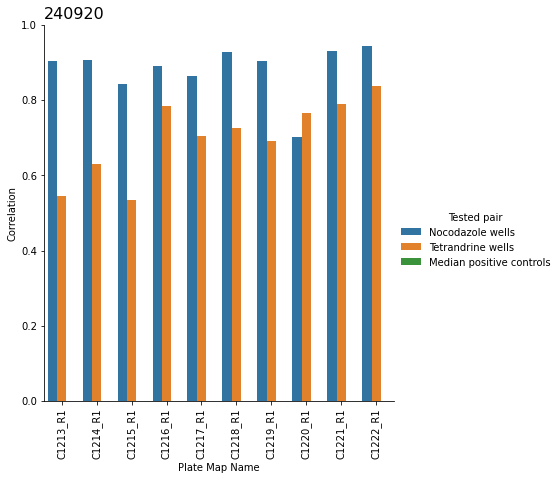

<Figure size 1008x504 with 0 Axes>

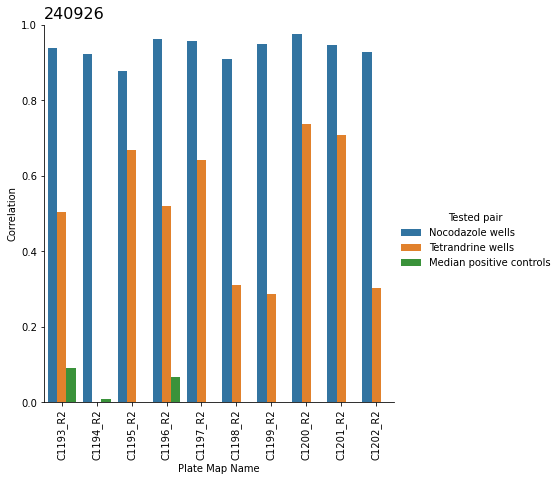

<Figure size 1008x504 with 0 Axes>

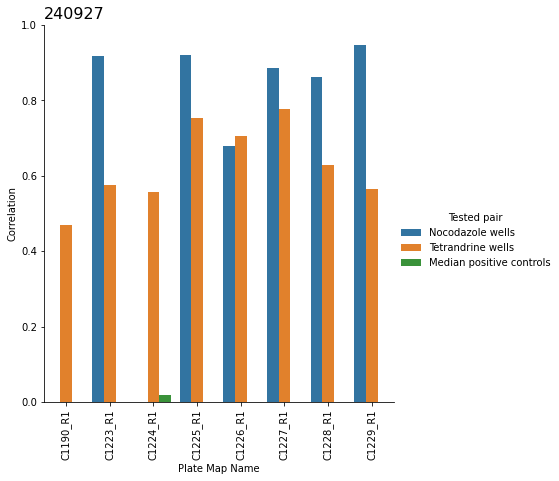

<Figure size 1008x504 with 0 Axes>

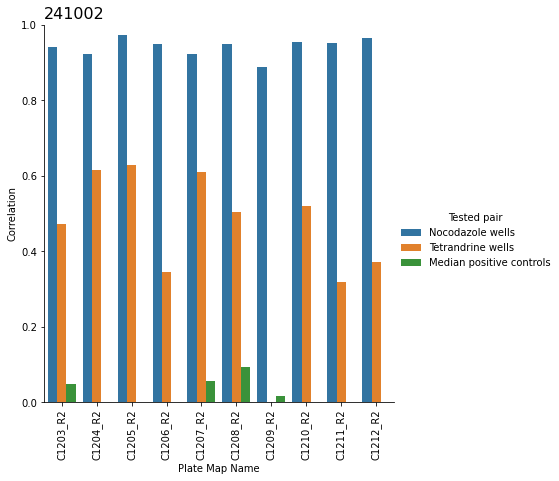

<Figure size 1008x504 with 0 Axes>

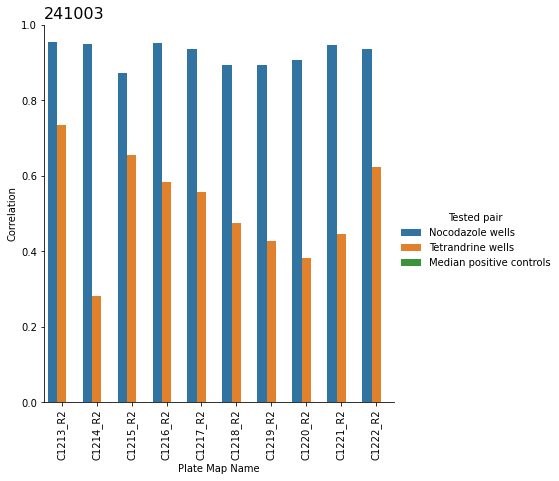

<Figure size 1008x504 with 0 Axes>

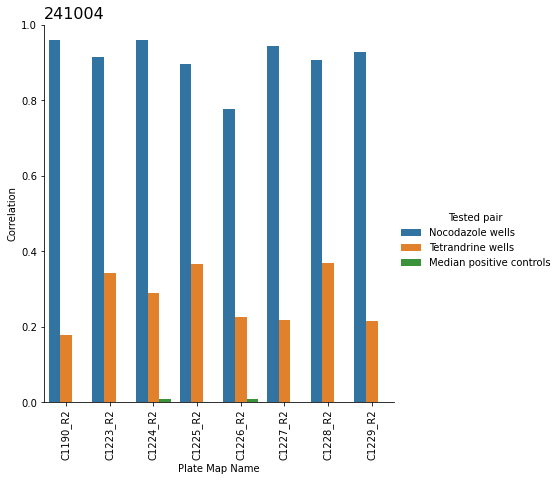

<Figure size 1008x504 with 0 Axes>

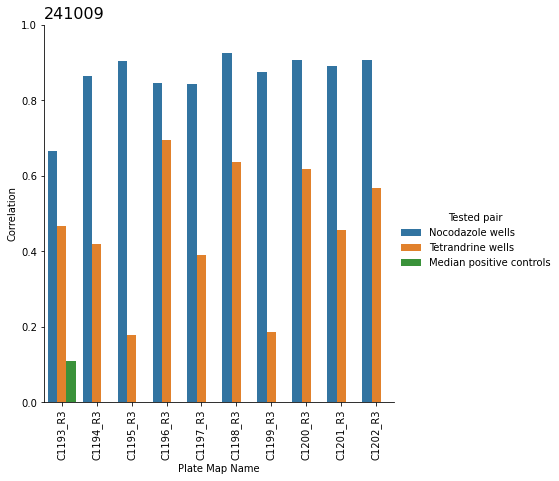

<Figure size 1008x504 with 0 Axes>

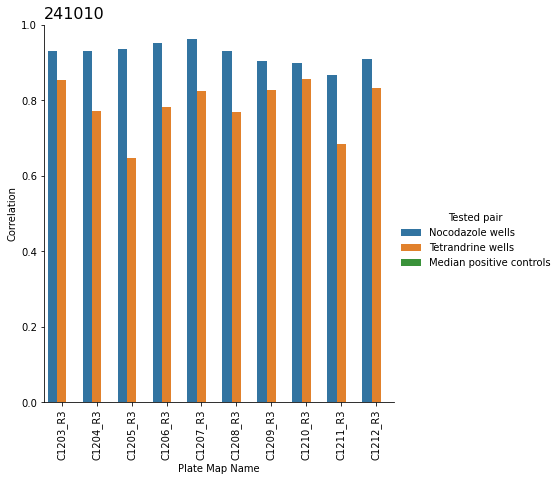

<Figure size 1008x504 with 0 Axes>

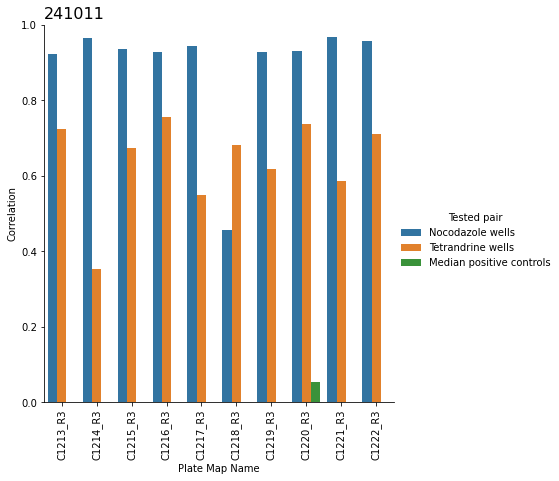

<Figure size 1008x504 with 0 Axes>

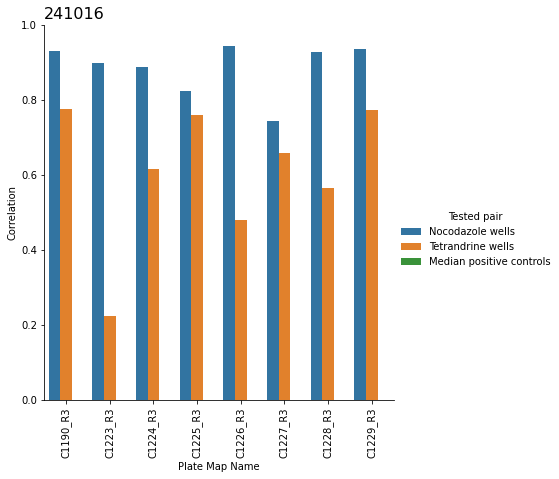

<Figure size 1008x504 with 0 Axes>

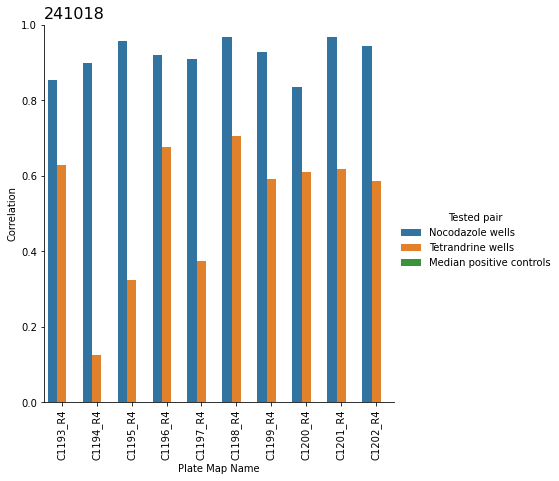

<Figure size 1008x504 with 0 Axes>

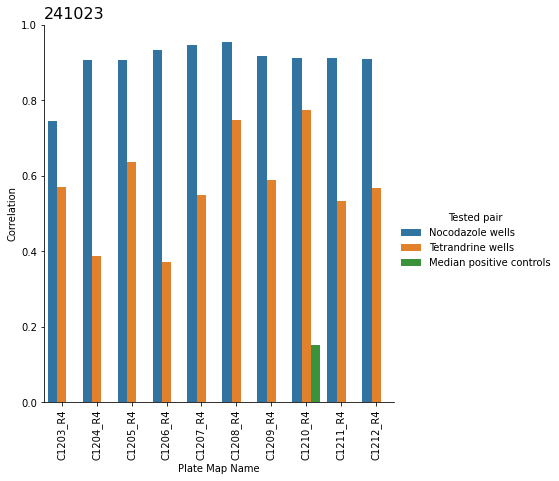

<Figure size 1008x504 with 0 Axes>

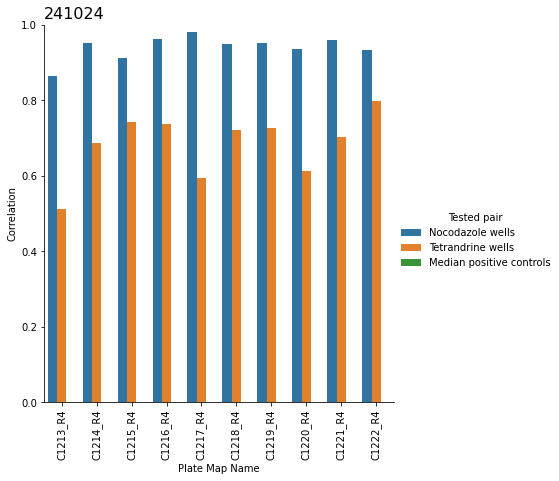

<Figure size 1008x504 with 0 Axes>

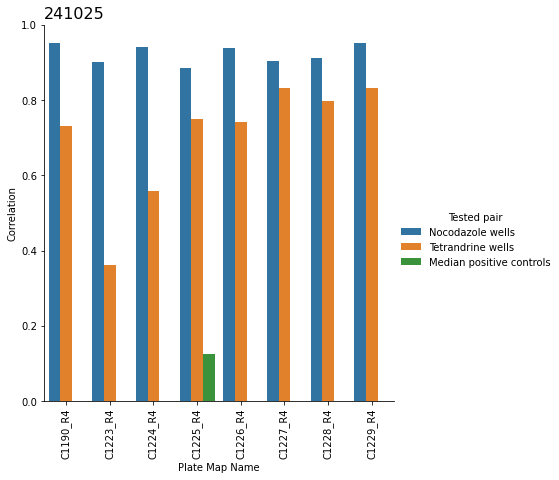

<Figure size 1008x504 with 0 Axes>

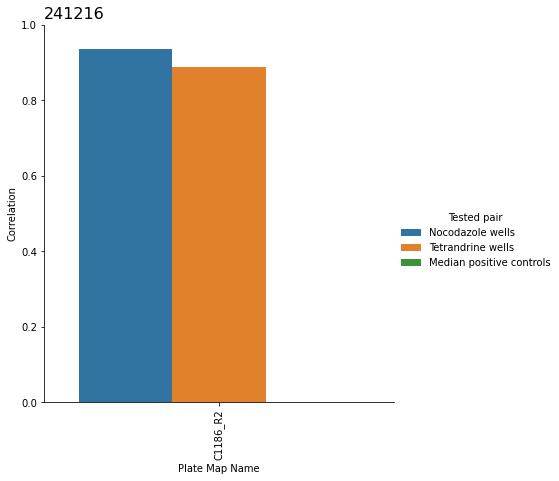

<Figure size 1008x504 with 0 Axes>

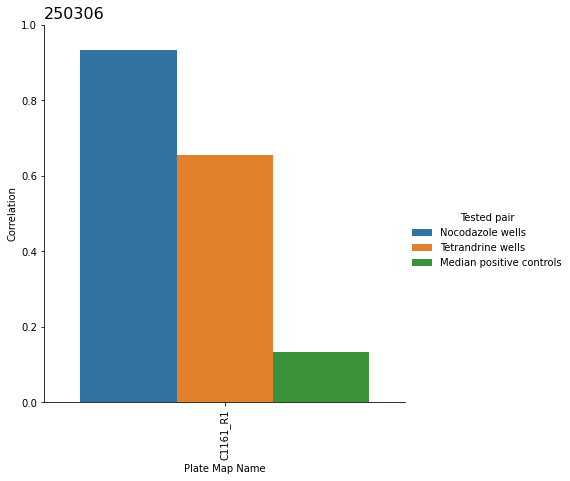

<Figure size 1008x504 with 0 Axes>

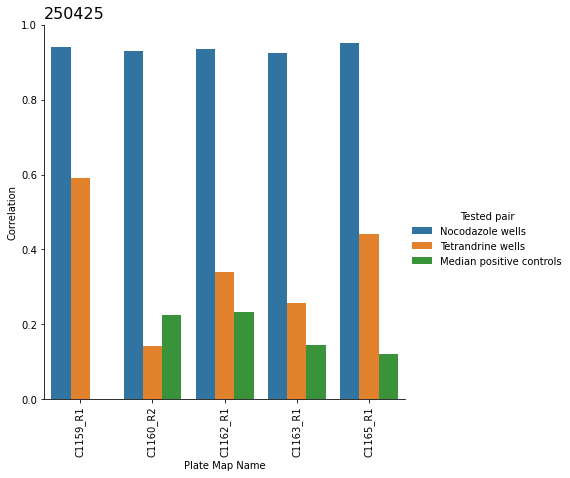

<Figure size 1008x504 with 0 Axes>

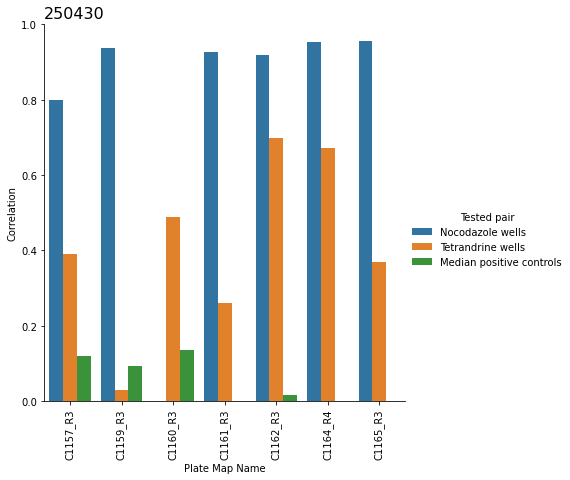

<Figure size 1008x504 with 0 Axes>

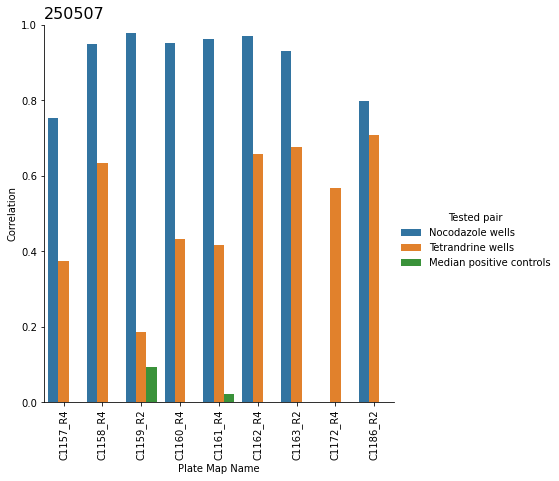

<Figure size 1008x504 with 0 Axes>

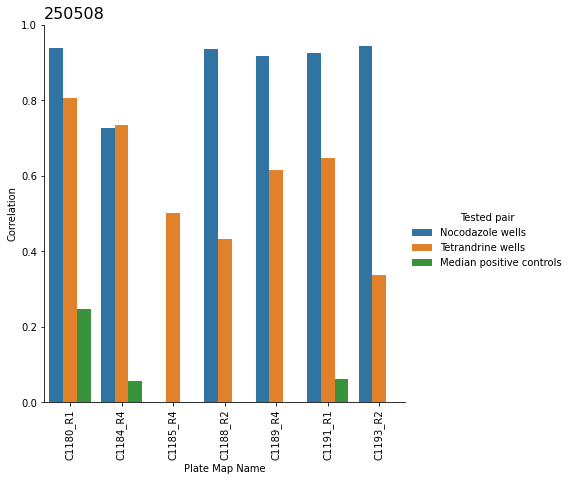

<Figure size 1008x504 with 0 Axes>

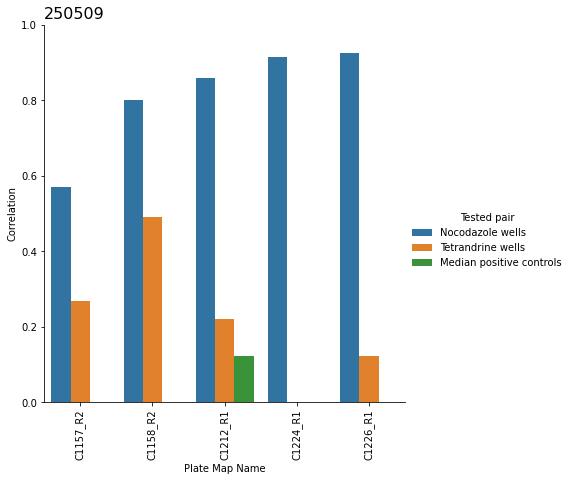

<Figure size 1008x504 with 0 Axes>

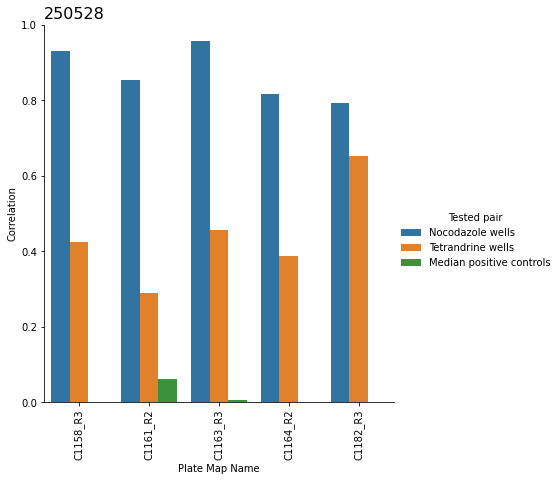

<Figure size 1008x504 with 0 Axes>

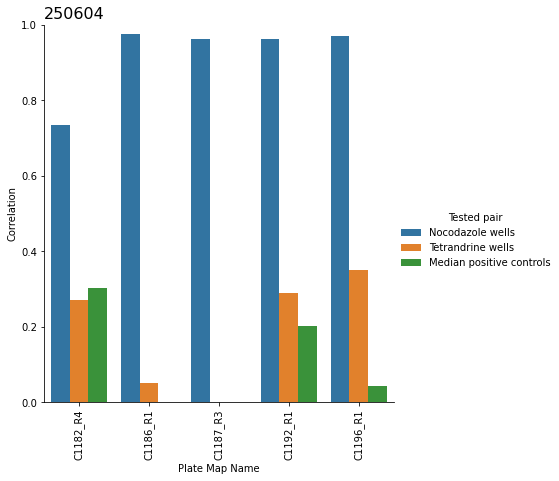

In [18]:
intra_plate_qc(quality_control_1_melt, 'USC', figure_path)